# Differential Expression Analysis for Dex_HDAC

We are interested in exploring the effect of histone deacetylase inhibitors (HDACi) on the transcription regulatory effects of dexamethasone, a GR agonist. In previous studies, dexamethasone treatment has been shown to cause **induction** and **repression** of many genes over time, comprising the anti-inflammatory response that the drug is generally used for. By studying the interaction between HDACi and Dexamethasone, we may reveal structural dependencies on HDACs for GR response and gain insight to combination drug effects between HDACi and Dexamethasone.

## GR Mechanism

Dexamethasone binds to glucocorticoid receptor (GR) in the cytosol of the cell. Activated-GR then translocates into the nucleus, where it upregulates anti-flammatory genes and downregulates pro-inflammatory genes. There exist pioneer factors, that is, transcription factors that can bind to condensed chromatin, are also involved in the GR response. AP1 and p300 guide GR for its epigenetic effects. 


## HDACs, HDACis, and Current Literature

Histone deacetylases are a class of proteins that are responsible for the deacetylation of lysine residues (and possibly other positively charged residues) via hydroylsis, which causes chromatin to be tightly wound around histones (**heterochromatin**) thereby preventing transcription. This effect is not exclusive to histones however. Studies have shown that [deacetylation via HDAC2 of GR enables NF-kB suppression](https://www.ncbi.nlm.nih.gov/pubmed/16380507), which is critical for anti-inflammation response. Individual HDACis such as SAHA (Vorinostat) have been shown to act via binding at the active site of histone deacetylases and chelating (forming coordinate  Zn2+ that is also found in the active site. This interferes with the Zinc-dependent hydrolysis of acetyl-L-lysine side chains for histone AND non-histone proteins. Therefore, this inhibits HDACs of class I, II, and IV (not III, which are sirtuins that are not zinc dependent). 

HDACs for different classes are shown below:

* Class I - HDACs 1 (nucleus), 2 (nucleus, GR as substrate), 3 (nucleus), and 8 (nucleus/cytoplasm)
* Class II - HDACs 4, 5, 6, 7, and 9, 10 (all can shuttle in and out of nucleus depending on signals)
* Class III - Sirtuins (SIRTI thru SIRT7, inside nucleus)
* Class IV - HDAC11

We are interested in the following HDACis, which are associated with the HDAC proteins they target:

* JNJ (Quisinostat) - Class I and II
* Romidepsin - Binds to Zinc via thiol, therefore hypothesized Class I, II, and IV
* SAHA (Vorinostat) - Class I, II, and IV
* TSA (Trichostatin A) - Class I and II

#### Non-histone effects

As previously stated, studies have shown that HDAC2 deacetylates GR in order to enable NF-kB suppression (thereby inhibiting pro-inflammatory response). HDAC 3 and 6 are also known to play an important role in the control of NF-kB pathway.

### NF-kappaB Model

There are several hypothesized models as to why and how testing the NF-KB model of repression for GC-HDACi treated cells. It is purported that deacetylation of GR via HDAC2 allows GR to bind to NF-kappaB, thereby inhibiting pro-inflammatory response. In other known models of GC-induced repression of NF-KB pathway, the GR-alpha may recruit HDAC2 to interact with the p65 CBP HAT complex, which inhibits expression. If cells are treated with HDACi, the effect of this mechanism would be lessened due to lower levels of available HDAC2, thus increasing expression of pro-inflammatory response.

However, we also expect inhibition of NF-kappaB via increased expression of IkB complexes. IkB complexes are a proposed mechanism for GR in that GR induces transcriptional activation for IkB complexes that repress NF-KB pathway. Because HDACi is reported to globally inhibit deacetylation (and thus increase the amount of chromatin in acetylated-stated), we expect a decrease in NF-KB expression due to this mechanism. 

##  Hypothesis

By inhibiting HDACs via HDACi, we expect that there will be a broad increase in transcripts across the genome. Out of the 4 HDACis in our study, Romidepsin and SAHA are known to affect Class I, II, and IV histone deacetylases, and we therefore expect for Romidepsin and SAHA samples to be most similar to each other, while we expect JNJ and TSA to be most similar to each other.

HDACs have been implicated to modify important nonhistone proteins such as p53 (cell cycle), NF-$\kappa$B (inflammation), STAT (immunity/cytokine signaling). We therefore expect to see these genes in the list of differentially expressed genes among our HDACi experiments.

# Data and Preprocessing

## Load R packages

In [1]:
require(tidyverse)
require(IRdisplay)
require(stringr)
require(DESeq2)
require(reshape2)
require('biomaRt')
require(UpSetR)
require(topGO)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: IRdisplay
Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

Th

In [2]:
ensembl <- useDataset("hsapiens_gene_ensembl", mart = useMart("ensembl"))

# 1) ONCE ONLY: Merge samples by treatment (i.e. DMSO_dex, JNJ_dex, etc)

Merge all samples that are under one treatment into a single file/matrix in order to load into DESeq2.

In [3]:
%%writefile /home/djy3/software/bin/MergeDataframes.py
import pandas as pd
import argparse

# Helper function, returns file basename of sample
def fileBasename(filename):
    strArgs = filename.split("/")
    return strArgs[len(strArgs)-1]

def main():
    parser = argparse.ArgumentParser(description='Merge multiple featureCount outputs into one matrix.')
    parser.add_argument('featureFiles', nargs='+', type=str, help='List of files to merge into one matrix')
    parser.add_argument('--out', required=True, type=str, help='Name of output file')
    args = parser.parse_args()

    arrFiles = args.featureFiles
    outFile = args.out

    # ENSG00000109320 - NFKB1
    # ENSG00000077150 - NFKB2
    # ENSG00000100906 - NFKBIA (IKBA)
    # ENSG00000104825 - NFKBIB (IKBB)
    # ENSG00000269335 - IKBKG    
    # subsetGenes = ('ENSG00000109320', 'ENSG00000077150', 'ENSG00000100906', 'ENSG00000104825', 'ENSG00000269335')

    assert len(arrFiles) > 1, "Must have more than 1 file in order to merge"
    mainDf = pd.read_csv(arrFiles[0], sep='\t', header=0, index_col=0, usecols=[0, 6])
    for i in range(1, len(arrFiles)):
        newDf = pd.read_csv(arrFiles[i], sep='\t', header=0, index_col=0, usecols=[0, 6])
        mainDf = mainDf.merge(newDf, how='outer', left_index=True, right_index=True)
        del(newDf)
    
    mainDf.to_csv(outFile, sep='\t')

if __name__ == '__main__':
    main()


ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected SPECIAL
1: %%
    ^


In [ ]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate Darryl
DATA_HOME=/data/reddylab/projects/ggr_hdaci/data/rna_seq
OUTPUT_DIR=/home/djy3/GGR_HDACi_Data

# File is formatted in 2 columns, treatment and control, where each control is the same
FACTORS=($(cut -f1 ${DATA_HOME}/metadata/project_factors.to_ctrl.txt))
# Extract the control
FACTORS+=($(head -n 1 ${DATA_HOME}/metadata/project_factors.to_ctrl.txt | cut -f2))

# For each treatment/control, combine all the timepoints into one file (featureCounts)
FILES=($(/bin/ls -1 ~/GGR_HDACi_Data/*featurecounts*))
clusterize -m 64000 -j "MergeDataframes" -c "python ~/software/bin/MergeDataframes.py \
    --out ~/GGR_HDACi_Data/A549.dex_hdaci.all_counts_new.txt ${FILES[*]}"


## ONCE ONLY: Create Metadata Spreadsheet For Differential Analysis

DESeq2 requires a metadata file that categorizes samples by different factors (i.e. timepoint, treatment, biological replicate).

In [ ]:
%%bash

# CREATE METADATA FOR READ COUNT FILES

OUTPUT_DIR=/home/djy3/GGR_HDACi_Data
OUTPUT_FILE=/home/djy3/GGR_HDACi_Data/A549.dex_HDACi.metadata.txt

echo -e "\tTreatment\tTimepoint\tRep" > ${OUTPUT_FILE}

# Read in samples
SAMPLES=($(head -n 1 ${OUTPUT_DIR}/A549.dex_hdaci.all_counts.txt | cut --complement -f 1))
for SAMPLE in ${SAMPLES[@]};
do
    TREATMENT=$(echo ${SAMPLE} | cut -d '.' -f 3)
    TIMEPOINT=$(echo ${SAMPLE} | grep -oP '(\d\dh)')
    REP=$(echo ${SAMPLE} | grep -oP '(rep\d)')
    if [[ ! -z $TREATMENT && ! -z $TIMEPOINT && ! -z REP ]];
    then
        echo -e "${SAMPLE}\t${TREATMENT}\t${TIMEPOINT}\t${REP}" >> ${OUTPUT_FILE}
    fi
done


In [ ]:
# %load /home/djy3/GGR_HDACi_Data/A549.dex_HDACi.metadata.txt
	Treatment	Timepoint	Rep
A549.rna_seq.DMSO.dex.00h.rep1.star2.Aligned.out.sorted.bam	DMSO	00h	rep1
A549.rna_seq.DMSO.dex.00h.rep2.star2.Aligned.out.sorted.bam	DMSO	00h	rep2
A549.rna_seq.DMSO.dex.00h.rep3.star2.Aligned.out.sorted.bam	DMSO	00h	rep3
A549.rna_seq.DMSO.dex.01h.rep1.star2.Aligned.out.sorted.bam	DMSO	01h	rep1
A549.rna_seq.DMSO.dex.01h.rep2.star2.Aligned.out.sorted.bam	DMSO	01h	rep2
A549.rna_seq.DMSO.dex.01h.rep3.star2.Aligned.out.sorted.bam	DMSO	01h	rep3
A549.rna_seq.DMSO.dex.04h.rep1.star2.Aligned.out.sorted.bam	DMSO	04h	rep1
A549.rna_seq.DMSO.dex.04h.rep2.star2.Aligned.out.sorted.bam	DMSO	04h	rep2
A549.rna_seq.JNJ.dex.00h.rep1.star2.Aligned.out.sorted.bam	JNJ	00h	rep1
A549.rna_seq.JNJ.dex.00h.rep2.star2.Aligned.out.sorted.bam	JNJ	00h	rep2
A549.rna_seq.JNJ.dex.01h.rep1.star2.Aligned.out.sorted.bam	JNJ	01h	rep1
A549.rna_seq.JNJ.dex.01h.rep2.star2.Aligned.out.sorted.bam	JNJ	01h	rep2
A549.rna_seq.JNJ.dex.01h.rep3.star2.Aligned.out.sorted.bam	JNJ	01h	rep3
A549.rna_seq.JNJ.dex.04h.rep1.star2.Aligned.out.sorted.bam	JNJ	04h	rep1
A549.rna_seq.JNJ.dex.04h.rep2.star2.Aligned.out.sorted.bam	JNJ	04h	rep2
A549.rna_seq.JNJ.dex.04h.rep3.star2.Aligned.out.sorted.bam	JNJ	04h	rep3
A549.rna_seq.Rom.dex.00h.rep1.star2.Aligned.out.sorted.bam	Rom	00h	rep1
A549.rna_seq.Rom.dex.00h.rep2.star2.Aligned.out.sorted.bam	Rom	00h	rep2
A549.rna_seq.Rom.dex.00h.rep3.star2.Aligned.out.sorted.bam	Rom	00h	rep3
A549.rna_seq.Rom.dex.01h.rep1.star2.Aligned.out.sorted.bam	Rom	01h	rep1
A549.rna_seq.Rom.dex.01h.rep2.star2.Aligned.out.sorted.bam	Rom	01h	rep2
A549.rna_seq.Rom.dex.01h.rep3.star2.Aligned.out.sorted.bam	Rom	01h	rep3
A549.rna_seq.Rom.dex.04h.rep1.star2.Aligned.out.sorted.bam	Rom	04h	rep1
A549.rna_seq.Rom.dex.04h.rep2.star2.Aligned.out.sorted.bam	Rom	04h	rep2
A549.rna_seq.Rom.dex.04h.rep3.star2.Aligned.out.sorted.bam	Rom	04h	rep3
A549.rna_seq.SAHA.dex.00h.rep1.star2.Aligned.out.sorted.bam	SAHA	00h	rep1
A549.rna_seq.SAHA.dex.00h.rep2.star2.Aligned.out.sorted.bam	SAHA	00h	rep2
A549.rna_seq.SAHA.dex.00h.rep3.star2.Aligned.out.sorted.bam	SAHA	00h	rep3
A549.rna_seq.SAHA.dex.01h.rep1.star2.Aligned.out.sorted.bam	SAHA	01h	rep1
A549.rna_seq.SAHA.dex.01h.rep2.star2.Aligned.out.sorted.bam	SAHA	01h	rep2
A549.rna_seq.SAHA.dex.01h.rep3.star2.Aligned.out.sorted.bam	SAHA	01h	rep3
A549.rna_seq.SAHA.dex.04h.rep1.star2.Aligned.out.sorted.bam	SAHA	04h	rep1
A549.rna_seq.SAHA.dex.04h.rep2.star2.Aligned.out.sorted.bam	SAHA	04h	rep2
A549.rna_seq.SAHA.dex.04h.rep3.star2.Aligned.out.sorted.bam	SAHA	04h	rep3
A549.rna_seq.TSA.dex.00h.rep1.star2.Aligned.out.sorted.bam	TSA	00h	rep1
A549.rna_seq.TSA.dex.00h.rep2.star2.Aligned.out.sorted.bam	TSA	00h	rep2
A549.rna_seq.TSA.dex.00h.rep3.star2.Aligned.out.sorted.bam	TSA	00h	rep3
A549.rna_seq.TSA.dex.01h.rep1.star2.Aligned.out.sorted.bam	TSA	01h	rep1
A549.rna_seq.TSA.dex.04h.rep1.star2.Aligned.out.sorted.bam	TSA	04h	rep1
A549.rna_seq.TSA.dex.04h.rep2.star2.Aligned.out.sorted.bam	TSA	04h	rep2
A549.rna_seq.TSA.dex.04h.rep3.star2.Aligned.out.sorted.bam	TSA	04h	rep3


## Perform Differential Expression Analysis within and across treatments

To check for timepoint effects, we first test for differential gene expression within treatments (i.e. across samples with same treatment, different timepoints with reference timepoint 00hr). Since the experiment utilized dexamathesone in combination with **4 separate types of HDACis**, we will need to create **4 DESeq models** for each different HDACi.


In [16]:
# Read in data
setwd('/home/djy3/GGR_HDACi_Data')

colData <- read.table('A549.dex_HDACi.metadata.txt', header = TRUE, sep = "\t", row.names = 1)
cts <- read.table('A549.dex_hdaci.all_counts.txt', header = TRUE, sep = "\t", row.names = 1)
    
##########################
#  Pre-processing Stage  #
##########################

# Create binary indicators for each HDACi
colData <- colData %>%
    rownames_to_column("Sample") %>%
    mutate(hasRom = case_when(str_detect(Treatment, "Rom") ~ TRUE,
                                                      TRUE ~ FALSE),
           hasJNJ = case_when(str_detect(Treatment, "JNJ") ~ TRUE,
                                                      TRUE ~ FALSE),
           hasTSA = case_when(str_detect(Treatment, "TSA") ~ TRUE,
                                                      TRUE ~ FALSE),
           hasSAHA = case_when(str_detect(Treatment, "SAHA") ~ TRUE,
                                                       TRUE  ~ FALSE))

# Make sure rows of metadata are equal to columns of count matrix
cts <- cts[colData$Sample]

# Create separate models for each HDACi: (i.e. TPM ~ Dex + Rom is separate from TPM ~ Dex + TSA)
# ~ROM~
tmpColData <- colData %>%
    filter(Treatment == "DMSO" | Treatment == "Rom")
tmpCts <- cts[tmpColData$Sample]
rom_dds <- DESeqDataSetFromMatrix(countData = tmpCts, colData = tmpColData,
                                  design = ~ Timepoint + hasRom + hasRom:Timepoint)

# ~JNJ~
tmpColData <- colData %>%
    filter(Treatment == "DMSO" | Treatment == "JNJ")
tmpCts <- cts[tmpColData$Sample]
jnj_dds <- DESeqDataSetFromMatrix(countData = tmpCts, colData = tmpColData,
                                  design = ~ Timepoint + hasJNJ + hasJNJ:Timepoint)

# ~TSA~
tmpColData <- colData %>%
    filter(Treatment == "DMSO" | Treatment == "TSA")
tmpCts <- cts[tmpColData$Sample]
tsa_dds <- DESeqDataSetFromMatrix(countData = tmpCts, colData = tmpColData,
                                  design = ~ Timepoint + hasTSA + hasTSA:Timepoint)

# ~SAHA~
tmpColData <- colData %>%
    filter(Treatment == "DMSO" | Treatment == "SAHA")
tmpCts <- cts[tmpColData$Sample]
saha_dds <- DESeqDataSetFromMatrix(countData = tmpCts, colData = tmpColData,
                                  design = ~ Timepoint + hasSAHA + hasSAHA:Timepoint)

remove(tmpColData, tmpCts)

# Subset (remove low read counts) and fit DESeq model
fitModel <- function(df, row_threshold) {
    df <- df[rowSums(counts(df)) > row_threshold, ]
    return(DESeq(df))
}
rom_dds <- fitModel(rom_dds, 1)
jnj_dds <- fitModel(jnj_dds, 1)
tsa_dds <- fitModel(tsa_dds, 1)
saha_dds <- fitModel(saha_dds, 1)


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## Variable Time Analysis, Dex + HDACi Interaction

Now we have 4 different models for each individual HDACi (`Romidepsin`, `JNJ`, `TSA`, `SAHA`). This model is a **generalized linear model (GLM)** with a formula modeling the log fold change in gene expression/transcript concentration $C_{transcript}$ attributed to each of the following coefficients:

* $\beta_{1hr}$ represents effect of dex at 1 hours, and $x$ is a binary indicator variable (1 = yes, 0 = no)
* $\beta_{4hr}$ represents effect of dex at 4 hours, and $y$ is a binary indicator variable
* $\beta_{hdaci}$ represents effect of HDACi alone, and $z$ is a binary indicator variable.
* Additional vars represent interaction terms between HDACi and different dex timepoints
* Each $\beta$ represents the effect in terms of log fold change effect in changing transcript concentration.

Given these definitions, the formula for $C_{transcript}$ is as follows:

$$\log_2 (C_{transcript}) = \beta_{0} + \beta_{1hr}x + \beta_{4hr} y + \beta_{hdaci}z + \beta_{hdaci:1hr}z + \beta_{hdaci:4hr}w$$

### Defining Dex + HDACi Contrast

Using `DESeq2` package, we define *contrasts*, which returns a differential expression profile for a given condition (i.e. control vs. HDACi only, or control vs. HDACi + Dex, etc). Here, we define the contrasts of Dex + HDACi by supplying a vector of binary indicators that indicate the condition we test. In this case, we are defining the contrast of Dex + HDACi including the interaction terms. We then place these results into a combined dataframe `res`:

In [17]:
##########################
# Variable-Time Analysis #
##########################

res <- NULL

### Differential analysis, model fit for Dex + HDACi effect ###

# For each HDACi model
for (df in list(rom_dds, jnj_dds, tsa_dds, saha_dds)) {
    
    # Get results for dex vs. dex-hdaci interaction terms
    hdaci_terms <- grep("Timepoint.*has.*TRUE", resultsNames(df), value = TRUE)
    
    # For each timepoint 01h, 04h
    for (term in hdaci_terms) {
        
        # Extract timepoint and HDACi name
        regex <- str_match(term, "^Timepoint(\\d{2}h).*has(.*)TRUE")
        timepoint <- regex[1,2]
        hdaci <- regex[1,3]
        
        # Intercept, timepoint1, timepoint4, hasHDACi, timepoint1:hasHDACi, timepoint4:hasHDACi
        model_vector = case_when(timepoint == "01h" ~ c(0, 1, 0, 1, 1, 0),
                                 timepoint == "04h" ~ c(0, 0, 1, 1, 0, 1))
        
        
        newRes <- results(df, contrast=model_vector, tidy=TRUE) %>%
                mutate(timepoint = timepoint,
                       treatment = paste(hdaci, "+", "Dex", sep = " "),
                       updown_reg = case_when(log2FoldChange > 0 ~ "up",
                                                 log2FoldChange < 0 ~ "down",
                                                 TRUE ~ NA_character_)) %>%
                dplyr::rename(gene = row)

        # Rename coefficient terms as "dex", "hdaci", and "dex_hdaci"
        dex_term <- paste0("Timepoint_", timepoint, "_vs_00h")
        hdaci_term <- paste0("has", hdaci, "TRUE")
        dex_hdaci_term <- paste0("Timepoint", timepoint, ".", "has", hdaci, "TRUE")
        coefs <- as.data.frame(coef(df)) %>%
            rownames_to_column("gene") %>%
            dplyr::select_("gene", dex_effect = dex_term, hdaci_effect = hdaci_term,
                           dex_hdaci_effect = dex_hdaci_term)
    
        
        newRes <- newRes %>%
            left_join(coefs, by = c("gene"))
        
        # Append all rows to `res` variable
        if (!is.null(res)) {
            res <- bind_rows(res, newRes)
        } else {
            res <- newRes
        }
    }
}

### Defining Dex-Only Contrast

We also want to investigate the gene expression effects attributed to Dexamethasone exclusively.
To do this, we define a Dex-Only contrast and add this to the dataframe `res` as well:

In [18]:
# Get results for Dex-Only effect for timepoint terms 01h, 04h
df <- rom_dds
timepoints <- grep("Timepoint_.*vs.*", resultsNames(rom_dds), value = TRUE)

# For each dex timepoint 01h, 04h
for (timepoint in timepoints) {
    regex <- str_match(timepoint, "^Timepoint_(\\d{2}h)_vs_(\\d{2}h)")
    timepoint_treat <- regex[1,2]
    timepoint_ref <- regex[1,3]
    
    # Intercept, timepoint1, timepoint4, hasHDACi, timepoint1:hasHDACi, timepoint4:hasHDACi
    model_vector = case_when(timepoint_treat == "01h" ~ c(0, 1, 0, 0, 0, 0),
                             timepoint_treat == "04h" ~ c(0, 0, 1, 0, 0, 0))

    newRes <- results(df, contrast=model_vector, tidy=TRUE) %>%
            mutate(timepoint = timepoint_treat,
                   treatment = "DMSO + Dex",
                   updown_reg = case_when(log2FoldChange > 0 ~ "up",
                                          log2FoldChange < 0 ~ "down",
                                          TRUE ~ NA_character_)) %>%
            dplyr::rename(gene = row)
    
    # Rename coefficient terms as "dex", "hdaci", and "dex_hdaci"
    dex_term <- paste0("Timepoint_", timepoint_treat, "_vs_00h")
    hdaci_term <- "hasRomTRUE"
    dex_hdaci_term <- paste0("Timepoint", timepoint_treat, ".", "hasRomTRUE")
    coefs <- as.data.frame(coef(df)) %>%
            rownames_to_column("gene") %>%
            dplyr::select_("gene", dex_effect = dex_term, hdaci_effect = hdaci_term,
                           dex_hdaci_effect = dex_hdaci_term)
    
    newRes <- newRes %>%
        left_join(coefs, by = c("gene"))
    
    # Append all rows to `res` variable
    if (!is.null(res)) {
        res <- bind_rows(res, newRes)
    } else {
        res <- newRes
    }
}

### Define HDACi-Only Contrast

We are also interested in the effects that HDACi has exclusively on gene expression. Here, we define an HDACi-only contrast and add this to our `res` dataframe.

In [19]:
# For each HDACi model
for (df in list(rom_dds, jnj_dds, tsa_dds, saha_dds)) {

    # Get model term name
    term <- grep("^has.*TRUE", resultsNames(df), value = TRUE)
    
    # Extract HDACi
    regex <- str_match(term, "^has(.*)TRUE$")
    hdaci <- regex[1,2]
    
    # Intercept, timepoint1, timepoint4, hasHDACi, timepoint1:hasHDACi, timepoint4:hasHDACi   
    model_vector <- c(0, 0, 0, 1, 0, 0)
        
        
    newRes <- results(df, contrast = model_vector, tidy = TRUE) %>%
            mutate(timepoint = "00h",
                   treatment = paste(hdaci, "+", "Dex", sep = " "),
                   updown_reg = case_when(log2FoldChange > 0 ~ "up",
                                          log2FoldChange < 0 ~ "down",
                                          TRUE ~ NA_character_)) %>%
            dplyr::rename(gene = row)

    # Rename coefficient term as "hdaci"
    hdaci_term <- paste0("has", hdaci, "TRUE")
    coefs <- as.data.frame(coef(df)) %>%
        rownames_to_column("gene") %>%
        dplyr::select_("gene", hdaci_effect = hdaci_term)
    
        
    newRes <- newRes %>%
        left_join(coefs, by = c("gene"))
        
    # Append all rows to `res` variable
    if (!is.null(res)) {
        res <- bind_rows(res, newRes)
    } else {
        res <- newRes
    }
}

## Add Gene Symbols and Descriptions

Now, we want to add HGNC Gene Symbols to our dataframe by converting the ENSEMBL gene numbers to gene symbols using `Biomart` package. We also add text descriptions to each gene as well:

In [20]:
### Add gene symbols for interpretation ###

# Strip version number from ensembl IDs
res <- res %>%
    separate(gene, c("gene", NA), sep = "[.]")

# Vectorize unique Ensembl IDs
ens_genes <- res %>%
    distinct(gene) %>%
    pull(gene)

# Get HGNC symbol, gene id, and description
G_list <- getBM(attributes = c("hgnc_symbol", "ensembl_gene_id", "description"),
                filters = "ensembl_gene_id", 
                values = ens_genes,
                mart = ensembl)

# Add values to the dataset
res <- res %>%
    left_join(G_list, by = c("gene" = "ensembl_gene_id"))

## Data display
Aggregated table of genes with treatment and dex timepoint:

In [21]:
glimpse(res)

Observations: 82,274
Variables: 15
$ gene             <chr> "ENSG00000238009", "ENSG00000241860", "ENSG0000027...
$ baseMean         <dbl> 7.400180e-02, 2.109733e+01, 2.658303e-01, 2.313741...
$ log2FoldChange   <dbl> -0.72900569, 0.26890180, -0.19085092, 1.32411754, ...
$ lfcSE            <dbl> 5.1344201, 0.4618751, 5.0455204, 0.4488882, 1.6531...
$ stat             <dbl> -0.14198404, 0.58219596, -0.03782581, 2.94977141, ...
$ pvalue           <dbl> 8.870926e-01, 5.604347e-01, 9.698266e-01, 3.180091...
$ padj             <dbl> NA, 6.545840e-01, NA, 7.036551e-03, 8.958065e-01, ...
$ timepoint        <chr> "01h", "01h", "01h", "01h", "01h", "01h", "01h", "...
$ treatment        <chr> "Rom + Dex", "Rom + Dex", "Rom + Dex", "Rom + Dex"...
$ updown_reg       <chr> "down", "up", "down", "up", "up", "down", "down", ...
$ dex_effect       <dbl> 0.35157522, 0.09864294, -1.89604962, 0.18249533, 0...
$ hdaci_effect     <dbl> -0.954759045, 0.287996850, -2.240580075, 1.2649468...
$ dex_hdaci_effec

## Larger Picture: Differential Expression by Treatment

Now, we broadly investigate the differential expression in genes across HDACi treatments by visualizing the number of significantly differentially expressed genes per treatment and timepoint and using heat map visualizations to show the effect sizes of these differences.

We also plot the overlaps of significant differentially expressed genes, both those with conserved regulation and those with altered regulation (i.e. up-regulated in DMSO and down-regulated in presence of HDACi):

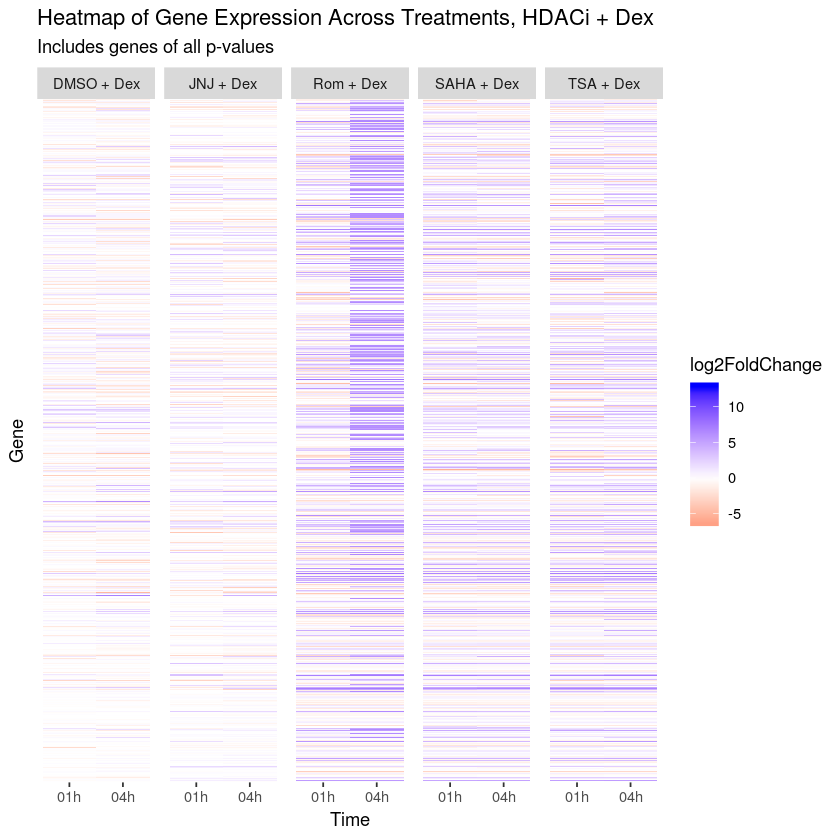

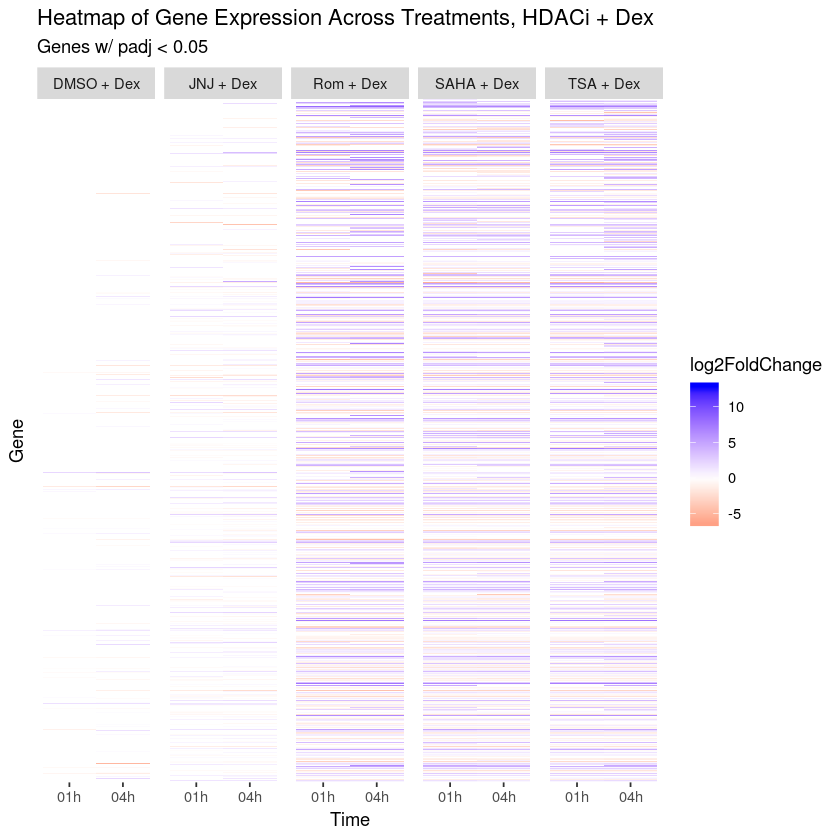

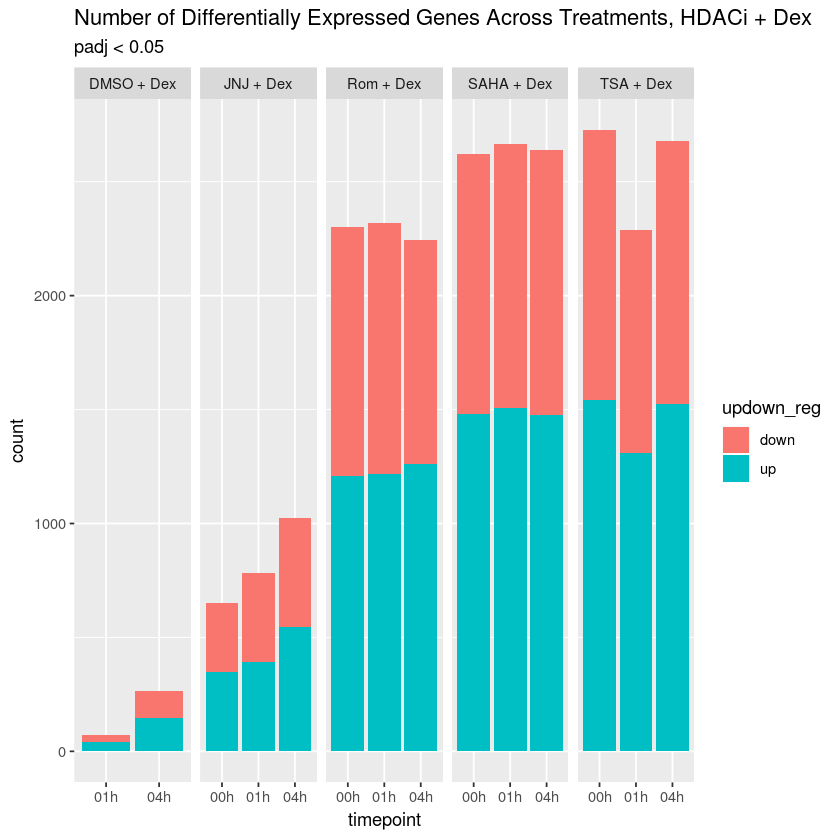

In [24]:
########
# Plot #
########

# Heatmap of Differential Expression (all)
res %>% 
    filter(timepoint != "00h") %>%
    ggplot(mapping = aes(x = timepoint, y = gene, fill = log2FoldChange)) +
    geom_tile() +
    facet_grid(. ~ treatment, scales = "free") +
    scale_fill_gradient2(low = "red", mid = "white", high = "blue") +
    labs(title = "Heatmap of Gene Expression Across Treatments, HDACi + Dex",
         subtitle = "Includes genes of all p-values",
         x = "Time",
         y = "Gene") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())


# Heatmap of Differential Expression (p < 0.05)
res %>%
    filter(padj < 0.05, timepoint != "00h") %>%
    ggplot(mapping = aes(x = timepoint, y = gene, fill = log2FoldChange)) +
    geom_tile() +
    facet_grid(. ~ treatment, scales = "free") +
    scale_fill_gradient2(low = "red", mid = "white", high = "blue") +
    labs(title = "Heatmap of Gene Expression Across Treatments, HDACi + Dex",
         subtitle = "Genes w/ padj < 0.05",
         x = "Time",
         y = "Gene") +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

#### Plot of differential gene counts ####
res %>%
    filter(padj < 0.05) %>%
    ggplot(mapping = aes(x = timepoint, fill = updown_reg)) +
    geom_bar() +
    facet_grid(. ~ treatment, scales = "free") +
    labs(title = 'Number of Differentially Expressed Genes Across Treatments, HDACi + Dex',
         subtitle = "padj < 0.05")

## Proportion of significant genes (p < 0.05)

Below, we display the relative proportions of significant genes, grouped by HDACi treatment and timepoint. The p-values used are adjusted by the Benjamini-Hochberg procedure, which controls the false discovery rate at level $\alpha = 0.05$.

treatment,timepoint,prop_sig,n
DMSO + Dex,01h,0.0122,73
DMSO + Dex,04h,0.0440,264
JNJ + Dex,00h,0.1183,653
JNJ + Dex,01h,0.1419,783
JNJ + Dex,04h,0.1857,1025
Rom + Dex,00h,0.3834,2301
Rom + Dex,01h,0.3861,2317
Rom + Dex,04h,0.3736,2242
SAHA + Dex,00h,0.4419,2622
SAHA + Dex,01h,0.4491,2665


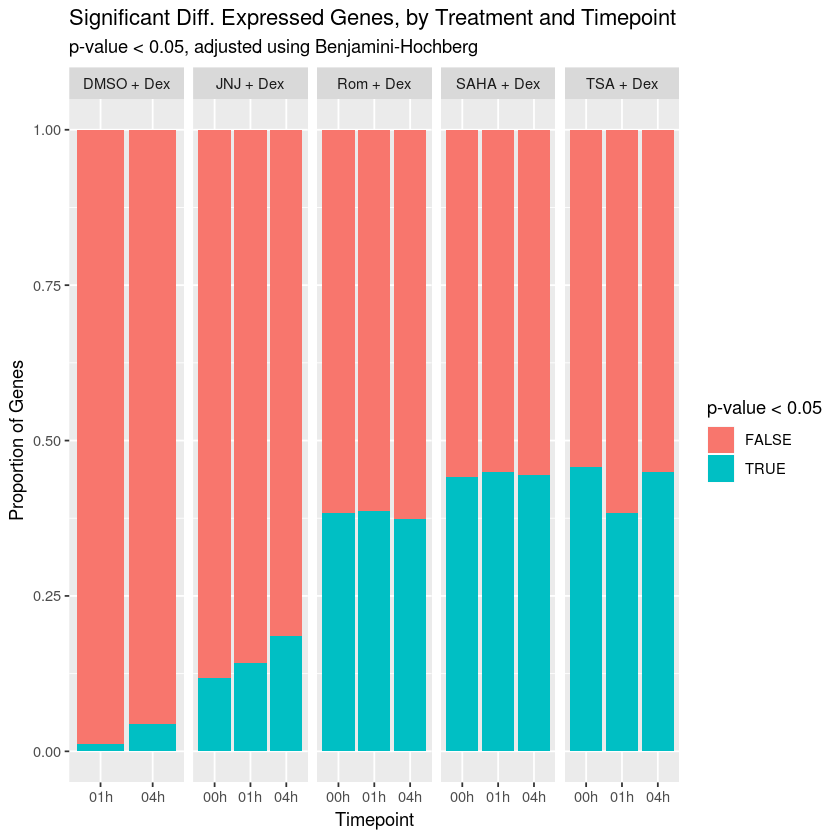

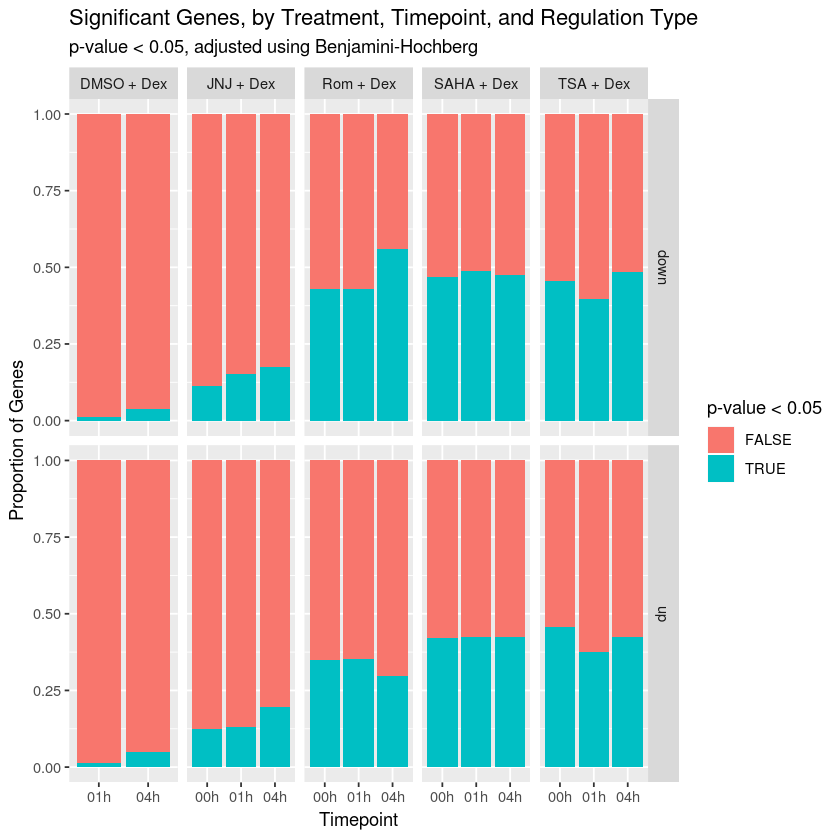

In [25]:
# Display proportion of significant genes (p < 0.05)
res %>%
    group_by(treatment, timepoint) %>%
    dplyr::count(sig = padj < 0.05) %>%
    mutate(prop_sig = round(n / sum(n), 4)) %>%
    filter(sig) %>%
    dplyr::select(treatment, timepoint, prop_sig, n)

# Display as segmented bar chart (overall)
res %>%
    group_by(treatment, timepoint) %>%
    dplyr::count(sig = case_when(padj < 0.05 ~ TRUE,
                                 TRUE ~ FALSE)) %>%
    mutate(prop_sig = round(n / sum(n), 4)) %>%
    ggplot(aes(x = timepoint, y = prop_sig, fill = sig)) +
    geom_bar(stat = "identity") +
    facet_grid(. ~ treatment, scales = "free") +
    labs(title = "Significant Diff. Expressed Genes, by Treatment and Timepoint",
         subtitle = "p-value < 0.05, adjusted using Benjamini-Hochberg",
         fill = "p-value < 0.05",
         x = "Timepoint",
         y = "Proportion of Genes")  

# Segmented bar chart, facetted by up/down regulation
res %>%
    group_by(treatment, timepoint, updown_reg) %>%
    dplyr::count(sig = case_when(padj < 0.05 ~ TRUE,
                                 TRUE ~ FALSE)) %>%
    mutate(prop_sig = round(n / sum(n), 4)) %>%
    ggplot(aes(x = timepoint, y = prop_sig, fill = sig)) +
    geom_bar(stat = "identity") +
    facet_grid(updown_reg ~ treatment, scales = "free") +
    labs(title = "Significant Genes, by Treatment, Timepoint, and Regulation Type",
         subtitle = "p-value < 0.05, adjusted using Benjamini-Hochberg",
         fill = "p-value < 0.05",
         x = "Timepoint",
         y = "Proportion of Genes")

## Intersection Analysis Between Treatments

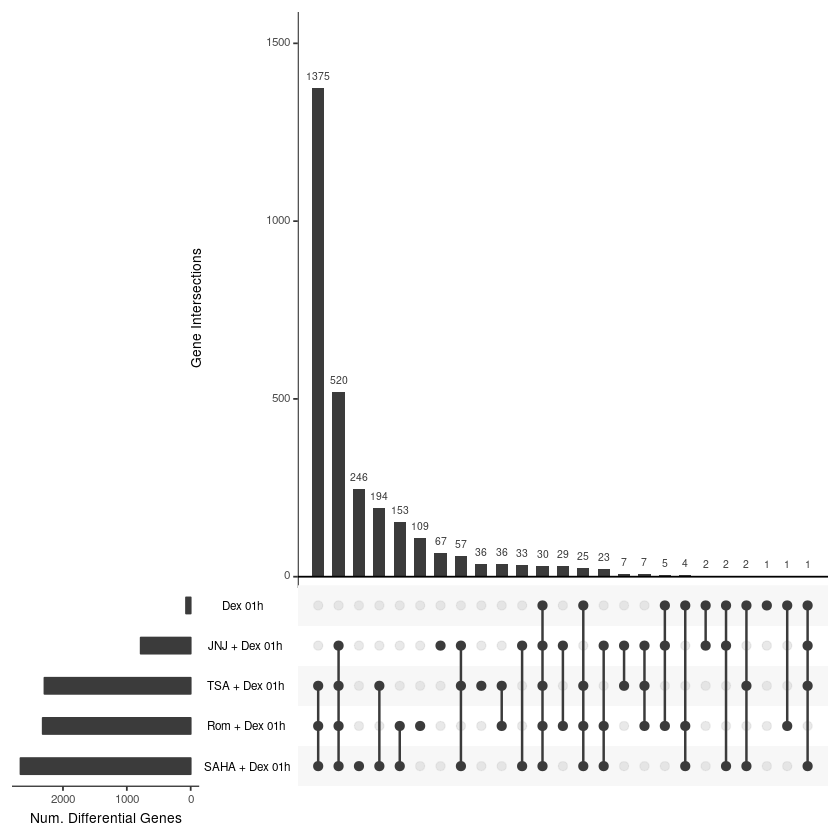

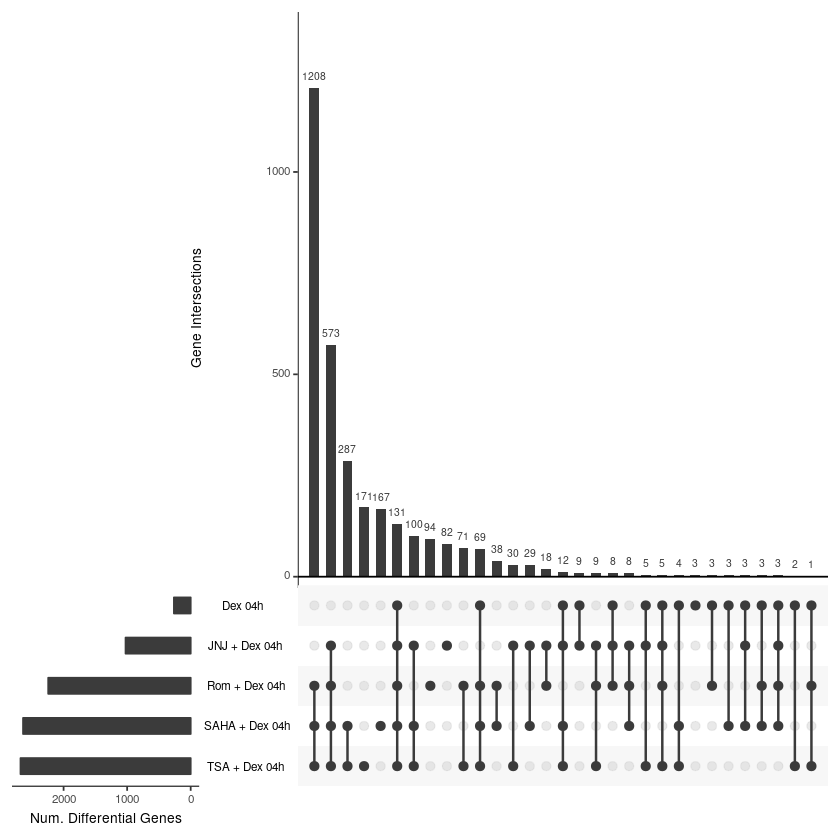

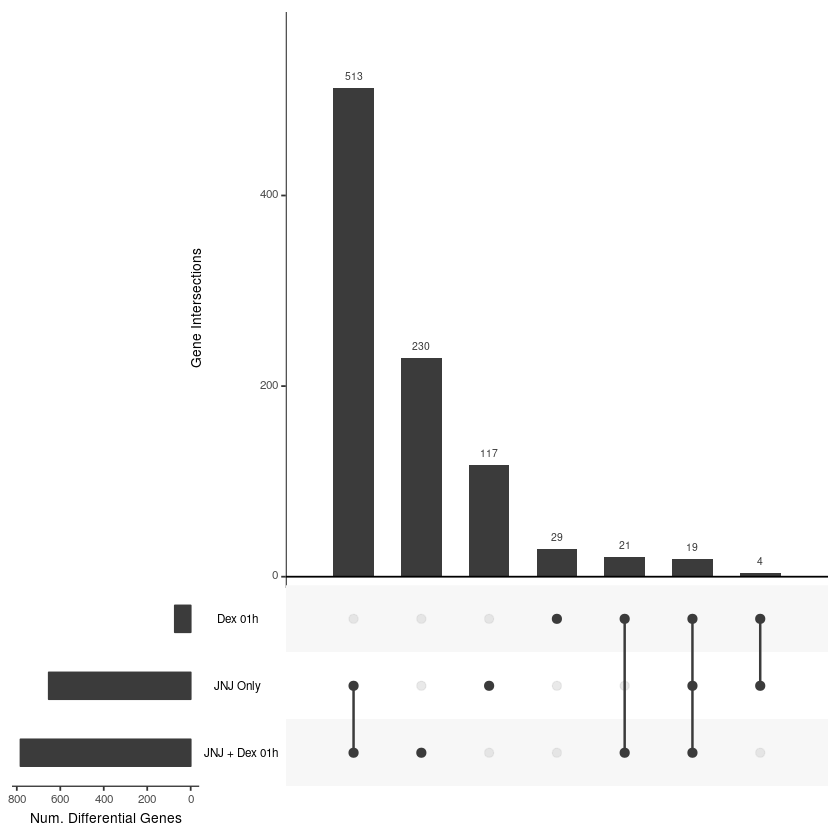

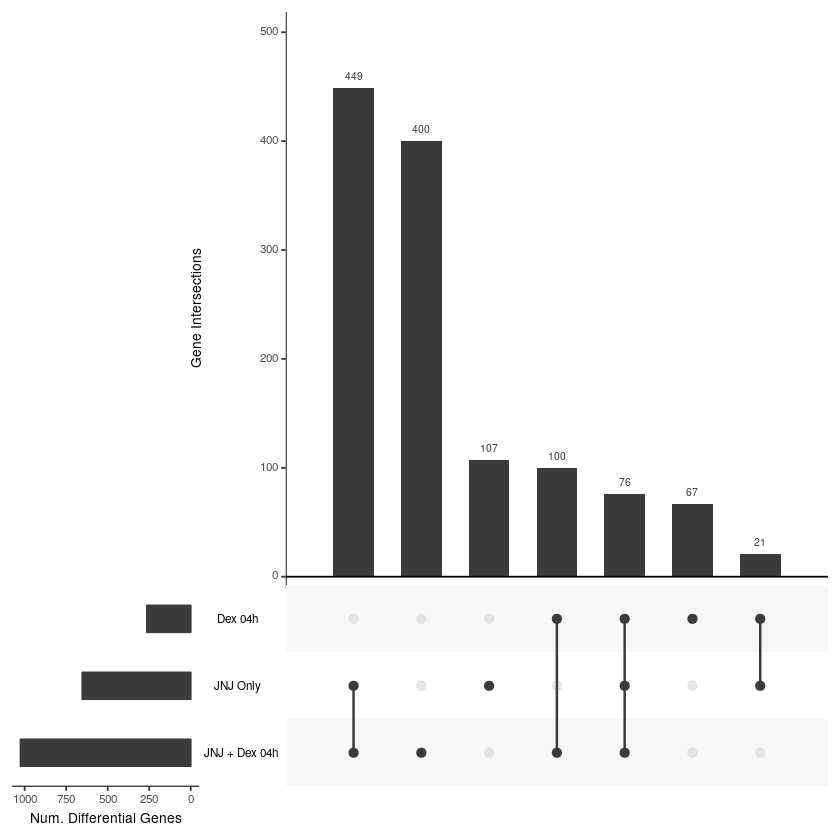

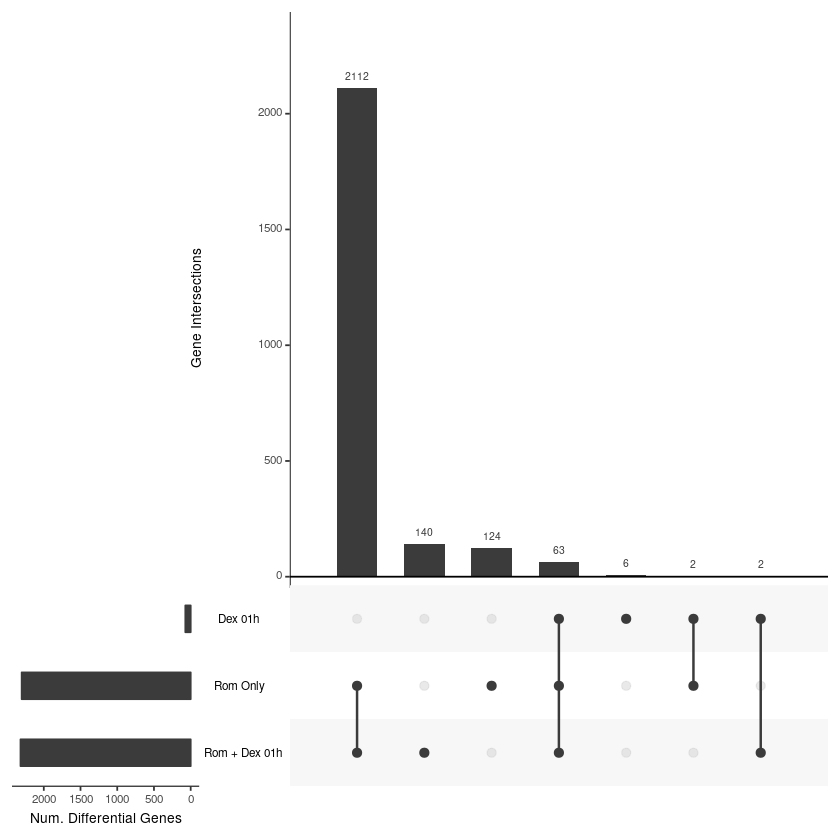

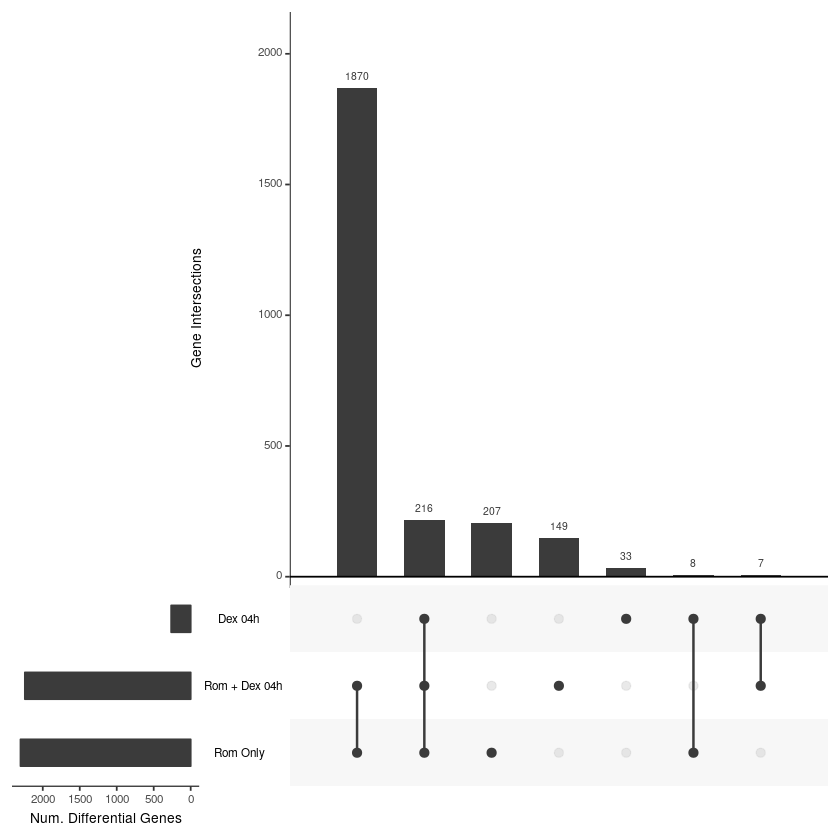

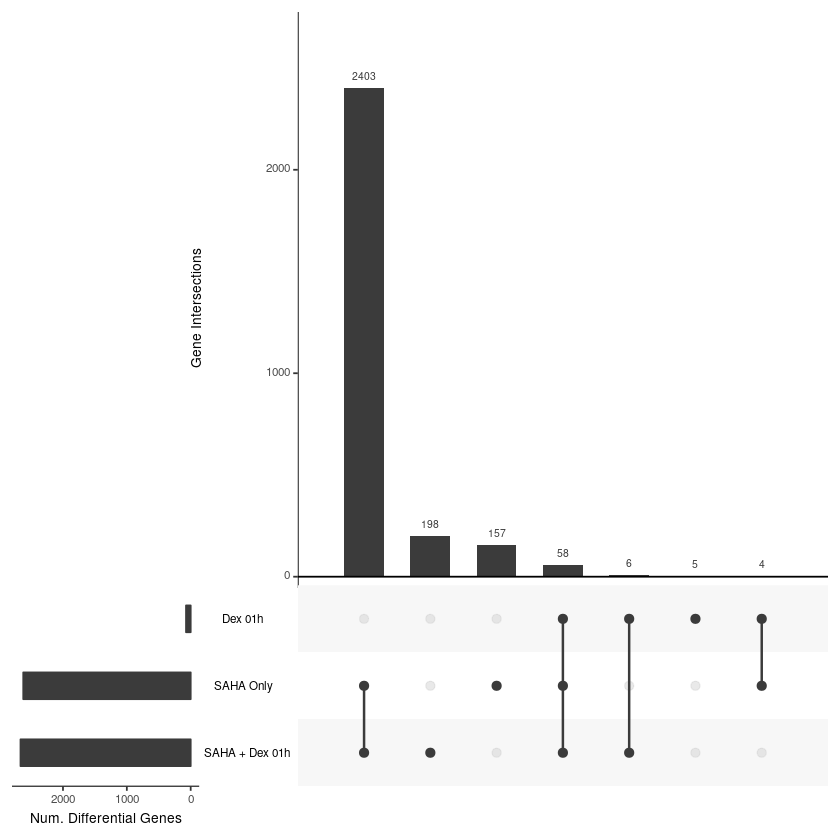

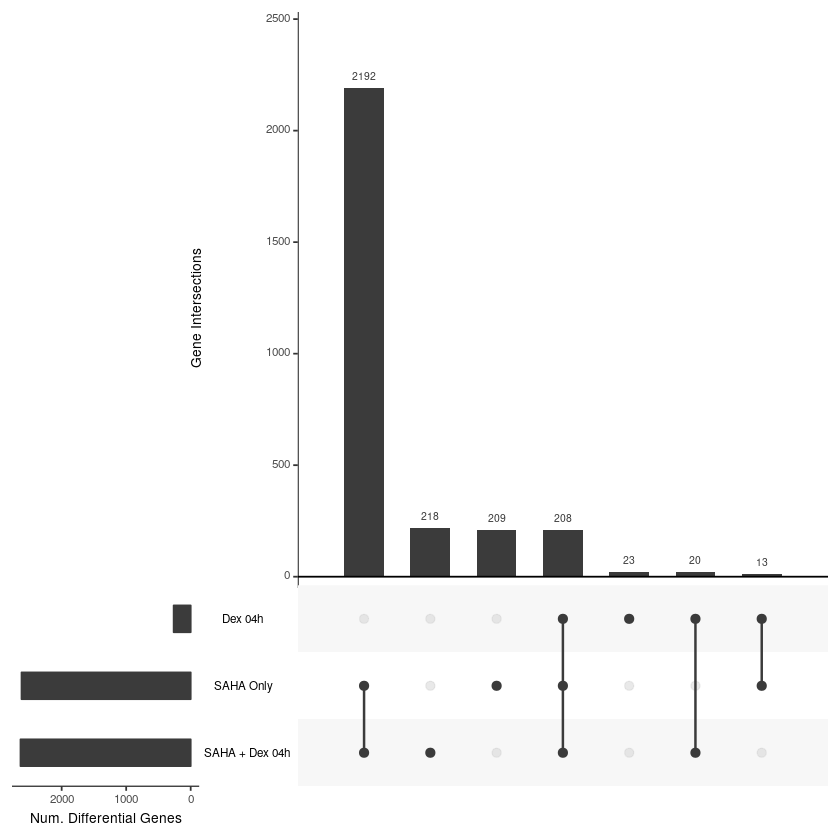

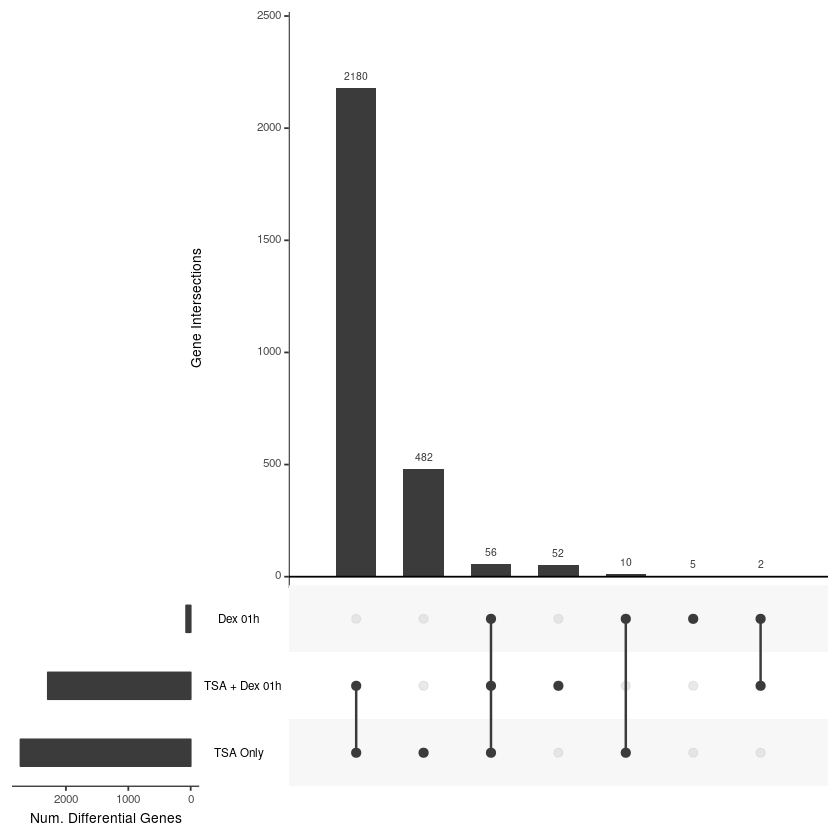

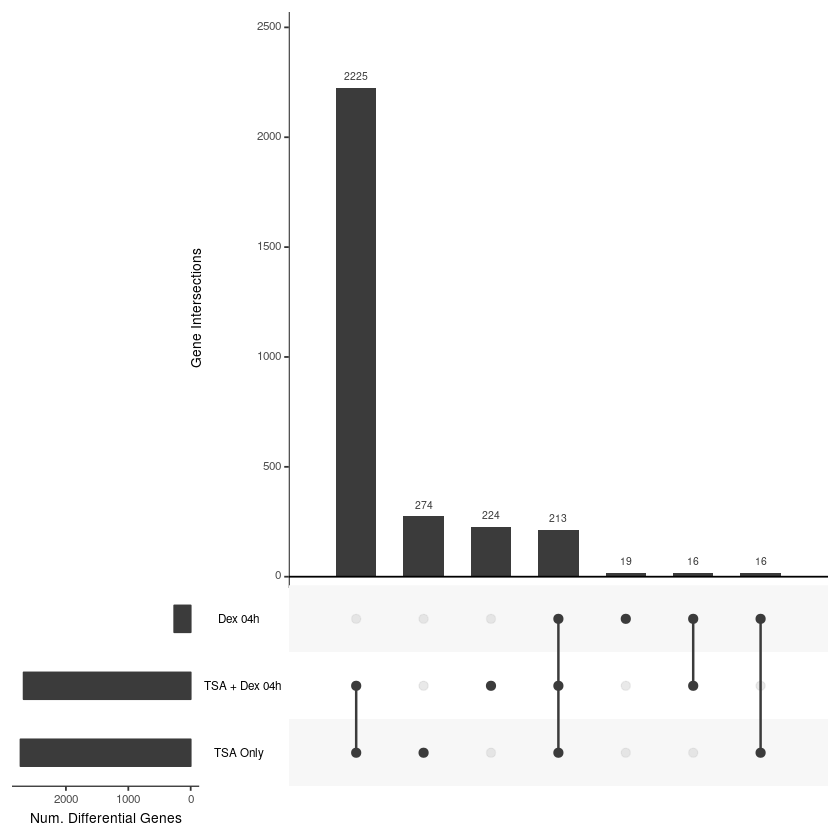

In [26]:
# Prepare data for usage in upsetr
upsetr_list_01h <- list(
    Dex = res %>% filter(padj < 0.05 & timepoint == "01h" & treatment == "DMSO + Dex") %>% pull(gene),
    JNJ_Dex = res %>% filter(padj < 0.05 & timepoint == "01h" & treatment == "JNJ + Dex") %>% pull(gene),
    ROM_Dex = res %>% filter(padj < 0.05 & timepoint == "01h" & treatment == "Rom + Dex") %>% pull(gene),
    SAHA_Dex = res %>% filter(padj < 0.05 & timepoint == "01h" & treatment == "SAHA + Dex") %>% pull(gene),
    TSA_Dex = res %>% filter(padj < 0.05 & timepoint == "01h" & treatment == "TSA + Dex") %>% pull(gene),
    JNJ = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "JNJ + Dex") %>% pull(gene),
    ROM = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "Rom + Dex") %>% pull(gene),
    SAHA = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "SAHA + Dex") %>% pull(gene),
    TSA = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "TSA + Dex") %>% pull(gene)
)

upsetr_list_04h <- list(
    DMSO = res %>% filter(padj < 0.05 & timepoint == "04h" & treatment == "DMSO + Dex") %>% pull(gene),
    JNJ_Dex = res %>% filter(padj < 0.05 & timepoint == "04h" & treatment == "JNJ + Dex") %>% pull(gene),
    ROM_Dex = res %>% filter(padj < 0.05 & timepoint == "04h" & treatment == "Rom + Dex") %>% pull(gene),
    SAHA_Dex = res %>% filter(padj < 0.05 & timepoint == "04h" & treatment == "SAHA + Dex") %>% pull(gene),
    TSA_Dex = res %>% filter(padj < 0.05 & timepoint == "04h" & treatment == "TSA + Dex") %>% pull(gene),
    JNJ = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "JNJ + Dex") %>% pull(gene),
    ROM = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "Rom + Dex") %>% pull(gene),
    SAHA = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "SAHA + Dex") %>% pull(gene),
    TSA = res %>% filter(padj < 0.05 & timepoint == "00h" & treatment == "TSA + Dex") %>% pull(gene)
)
names(upsetr_list_01h) <- c("Dex 01h", "JNJ + Dex 01h", "Rom + Dex 01h", "SAHA + Dex 01h", "TSA + Dex 01h",
                            "JNJ Only", "Rom Only", "SAHA Only", "TSA Only")

names(upsetr_list_04h) <- c("Dex 04h", "JNJ + Dex 04h", "Rom + Dex 04h", "SAHA + Dex 04h", "TSA + Dex 04h",
                            "JNJ Only", "Rom Only", "SAHA Only", "TSA Only")

# Plot 01h genes
upset(fromList(upsetr_list_01h), order.by = "freq",
      sets = c("Dex 01h", "JNJ + Dex 01h", "Rom + Dex 01h", "SAHA + Dex 01h", "TSA + Dex 01h"),
      sets.x.label = "Num. Differential Genes", mainbar.y.label = "Gene Intersections")

# Plot 04h genes
upset(fromList(upsetr_list_04h), order.by = "freq",
      sets = c("Dex 04h", "JNJ + Dex 04h", "Rom + Dex 04h", "SAHA + Dex 04h", "TSA + Dex 04h"),
      sets.x.label = "Num. Differential Genes", mainbar.y.label = "Gene Intersections")


# By HDACi and timepoint
plot_upset <- function(hdaci, hr) {
    if (hr == "01h") { upset_list <- upsetr_list_01h }
    else if (hr == "04h") { upset_list <- upsetr_list_04h }
    else { stop() }

    custom_sets <- c(paste("Dex", hr),
                     paste(hdaci, "+", "Dex", hr),
                     paste(hdaci, "Only"))
    upset(fromList(upset_list), order.by = "freq",
          sets = custom_sets,
          sets.x.label = "Num. Differential Genes", mainbar.y.label = "Gene Intersections")
}

for (hdaci in c("JNJ", "Rom", "SAHA", "TSA")) {
    for (hr in c("01h", "04h")) {
        plot_upset(hdaci, hr)
    }
}


## Rough Analysis of Top Genes

Below, we sort genes by adjusted p-value and output the top 20 genes. That is, we output the genes that have the most evidence for differential expression.

In [27]:
###############################
#    Analysis of Top Genes    #
###############################


### Top 20 Up-Regulated Genes ###
cat("\n ---- Top 20 Up-Reg Genes ----\n")
res %>%
    filter(log2FoldChange > 0) %>%
    arrange(padj) %>%
    distinct(hgnc_symbol, .keep_all = TRUE) %>%
    dplyr::select(hgnc_symbol, treatment, timepoint, log2FoldChange, padj, description) %>%
    #dplyr::select(hgnc_symbol, updown_reg, treatment, timepoint, baseMean, 
    #              log2FoldChange, lfcSE, stat, pvalue, padj)) %>%
    head(20)

### Top 20 Down-Regulated Genes ###
cat("\n ---- Top 20 Dn-Reg Genes ----\n")
res %>%
    filter(log2FoldChange < 0) %>%
    arrange(padj) %>%
    distinct(hgnc_symbol, .keep_all = TRUE) %>%
    dplyr::select(hgnc_symbol, log2FoldChange, padj, description) %>%
    #dplyr::select(hgnc_symbol, treatment, updown_reg, timepoint, baseMean, 
    #              log2FoldChange, lfcSE, stat, pvalue, padj)) %>%
    head(20)

### NFKB Genes ###
cat("\n ---- NFKB Genes ---- \n")
#genePairs %>%
#      filter((hgnc_symbol.x %in% c("NFKB1", "NFKB2", "NFKBIA", "NFKBIB", "IKBKG")) &
#              treatment.x < treatment.y) %>%
#      dplyr::select(hgnc_symbol.x, timepoint, 
#                    treatment.x, log2FoldChange.x, padj.x,
#                    treatment.y, log2FoldChange.y, padj.y) %>%
#      arrange(padj.x, padj.y)




 ---- Top 20 Up-Reg Genes ----


hgnc_symbol,treatment,timepoint,log2FoldChange,padj,description
CGN,Rom + Dex,01h,3.249615,0.000000e+00,cingulin [Source:HGNC Symbol;Acc:HGNC:17429]
SYT11,Rom + Dex,01h,4.702996,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
AREG,Rom + Dex,01h,4.685673,0.000000e+00,amphiregulin [Source:HGNC Symbol;Acc:HGNC:651]
ANKRD1,Rom + Dex,01h,6.086221,0.000000e+00,ankyrin repeat domain 1 [Source:HGNC Symbol;Acc:HGNC:15819]
CEP131,Rom + Dex,01h,2.871136,0.000000e+00,centrosomal protein 131 [Source:HGNC Symbol;Acc:HGNC:29511]
HELZ2,Rom + Dex,01h,2.962564,0.000000e+00,helicase with zinc finger 2 [Source:HGNC Symbol;Acc:HGNC:30021]
CEND1,TSA + Dex,01h,5.369793,0.000000e+00,cell cycle exit and neuronal differentiation 1 [Source:HGNC Symbol;Acc:HGNC:24153]
TUBB4A,TSA + Dex,01h,4.033495,0.000000e+00,tubulin beta 4A class IVa [Source:HGNC Symbol;Acc:HGNC:20774]
NOVA2,TSA + Dex,04h,4.864408,0.000000e+00,NOVA alternative splicing regulator 2 [Source:HGNC Symbol;Acc:HGNC:7887]
RCN3,TSA + Dex,04h,4.080117,0.000000e+00,reticulocalbin 3 [Source:HGNC Symbol;Acc:HGNC:21145]



 ---- Top 20 Dn-Reg Genes ----


hgnc_symbol,log2FoldChange,padj,description
ITGB5,-1.838772,0.000000e+00,integrin subunit beta 5 [Source:HGNC Symbol;Acc:HGNC:6160]
RAI14,-2.254404,0.000000e+00,retinoic acid induced 14 [Source:HGNC Symbol;Acc:HGNC:14873]
MAP7,-3.012052,0.000000e+00,microtubule associated protein 7 [Source:HGNC Symbol;Acc:HGNC:6869]
HTATIP2,-2.177477,0.000000e+00,HIV-1 Tat interactive protein 2 [Source:HGNC Symbol;Acc:HGNC:16637]
,-2.995255,0.000000e+00,lymphotoxin beta receptor [Source:NCBI gene;Acc:4055]
XPOT,-2.284689,0.000000e+00,exportin for tRNA [Source:HGNC Symbol;Acc:HGNC:12826]
AKR1B10,-4.347687,0.000000e+00,aldo-keto reductase family 1 member B10 [Source:HGNC Symbol;Acc:HGNC:382]
ALDH3B1,-3.620631,0.000000e+00,aldehyde dehydrogenase 3 family member B1 [Source:HGNC Symbol;Acc:HGNC:410]
TSKU,-3.140684,0.000000e+00,"tsukushi, small leucine rich proteoglycan [Source:HGNC Symbol;Acc:HGNC:28850]"
SRC,-3.051494,0.000000e+00,"SRC proto-oncogene, non-receptor tyrosine kinase [Source:HGNC Symbol;Acc:HGNC:11283]"



 ---- NFKB Genes ---- 


In [28]:
################################
#   Across Treatment Compare   #
################################

exclusive_treatment <- function(hdaci) {
    df <- res %>% filter(treatment == paste(hdaci, "+", "Dex"))
    
    #print(paste("\n------", "Top 20", hdaci, "+ Dex Genes, Up-Reg", "------\n"))
    
    df %>%
        filter(log2FoldChange > 0, padj < 0.05) %>%
        anti_join(res %>% filter(treatment == "DMSO + Dex", padj < 0.05), by = c("gene", "timepoint")) %>%
        anti_join(res %>% filter(treatment == hdaci, padj < 0.05), by = c("gene")) %>%
        arrange(padj) %>%
        mutate(id = row_number()) %>%
        head(20) %>%
        dplyr::select(id, gene, hgnc_symbol, treatment, log2FoldChange, padj, description) %>%
        display()
    
    #print(paste("\n------", "Top 20", hdaci, "+ Dex Genes, Dn-Reg", "------\n"))
    
    df %>%
        filter(log2FoldChange < 0, padj < 0.05) %>%
        anti_join(res %>% filter(treatment == "DMSO + Dex", padj < 0.05), by = c("gene", "timepoint")) %>%
        anti_join(res %>% filter(treatment == hdaci, padj < 0.05), by = c("gene")) %>%
        arrange(padj) %>%
        mutate(id = row_number()) %>%
        head(20) %>%
        dplyr::select(id, gene, hgnc_symbol, treatment, log2FoldChange, padj, description) %>%
        display()
}

for (hdaci in c("JNJ", "Rom", "SAHA", "TSA")) {
    exclusive_treatment(hdaci)
}

id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000104967,NOVA2,JNJ + Dex,1.8671023,1.021085e-32,NOVA alternative splicing regulator 2 [Source:HGNC Symbol;Acc:HGNC:7887]
2,ENSG00000104967,NOVA2,JNJ + Dex,2.0578075,1.713658e-32,NOVA alternative splicing regulator 2 [Source:HGNC Symbol;Acc:HGNC:7887]
3,ENSG00000155629,PIK3AP1,JNJ + Dex,1.3688103,1.890355e-28,phosphoinositide-3-kinase adaptor protein 1 [Source:HGNC Symbol;Acc:HGNC:30034]
4,ENSG00000077684,JADE1,JNJ + Dex,0.6331826,4.386126e-28,jade family PHD finger 1 [Source:HGNC Symbol;Acc:HGNC:30027]
5,ENSG00000161249,DMKN,JNJ + Dex,1.2531917,4.446334e-27,dermokine [Source:HGNC Symbol;Acc:HGNC:25063]
6,ENSG00000100626,GALNT16,JNJ + Dex,1.3761295,7.263852e-27,polypeptide N-acetylgalactosaminyltransferase 16 [Source:HGNC Symbol;Acc:HGNC:23233]
7,ENSG00000100626,GALNT16,JNJ + Dex,1.1993517,2.836794e-25,polypeptide N-acetylgalactosaminyltransferase 16 [Source:HGNC Symbol;Acc:HGNC:23233]
8,ENSG00000100626,GALNT16,JNJ + Dex,1.1846613,9.826509e-25,polypeptide N-acetylgalactosaminyltransferase 16 [Source:HGNC Symbol;Acc:HGNC:23233]
9,ENSG00000155629,PIK3AP1,JNJ + Dex,1.2500394,1.018842e-23,phosphoinositide-3-kinase adaptor protein 1 [Source:HGNC Symbol;Acc:HGNC:30034]
10,ENSG00000126970,ZC4H2,JNJ + Dex,1.1848470,3.202501e-23,zinc finger C4H2-type containing [Source:HGNC Symbol;Acc:HGNC:24931]


id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000130779,CLIP1,JNJ + Dex,-0.7878977,1.137397e-60,CAP-Gly domain containing linker protein 1 [Source:HGNC Symbol;Acc:HGNC:10461]
2,ENSG00000103154,NECAB2,JNJ + Dex,-1.3885028,4.060137e-50,N-terminal EF-hand calcium binding protein 2 [Source:HGNC Symbol;Acc:HGNC:23746]
3,ENSG00000131459,GFPT2,JNJ + Dex,-0.9605236,2.171847e-49,glutamine-fructose-6-phosphate transaminase 2 [Source:HGNC Symbol;Acc:HGNC:4242]
4,ENSG00000131459,GFPT2,JNJ + Dex,-0.8255719,3.804792e-37,glutamine-fructose-6-phosphate transaminase 2 [Source:HGNC Symbol;Acc:HGNC:4242]
5,ENSG00000103154,NECAB2,JNJ + Dex,-1.3611917,8.292537e-37,N-terminal EF-hand calcium binding protein 2 [Source:HGNC Symbol;Acc:HGNC:23746]
6,ENSG00000158373,HIST1H2BD,JNJ + Dex,-1.1284556,2.722344e-33,histone cluster 1 H2B family member d [Source:HGNC Symbol;Acc:HGNC:4747]
7,ENSG00000131459,GFPT2,JNJ + Dex,-0.8490066,2.808512e-30,glutamine-fructose-6-phosphate transaminase 2 [Source:HGNC Symbol;Acc:HGNC:4242]
8,ENSG00000165280,VCP,JNJ + Dex,-0.6078821,9.021098e-29,valosin containing protein [Source:HGNC Symbol;Acc:HGNC:12666]
9,ENSG00000181027,FKRP,JNJ + Dex,-0.6595896,5.429301e-25,fukutin related protein [Source:HGNC Symbol;Acc:HGNC:17997]
10,ENSG00000130779,CLIP1,JNJ + Dex,-0.4934022,3.111536e-24,CAP-Gly domain containing linker protein 1 [Source:HGNC Symbol;Acc:HGNC:10461]


id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000143375,CGN,Rom + Dex,3.249615,0.000000e+00,cingulin [Source:HGNC Symbol;Acc:HGNC:17429]
2,ENSG00000132718,SYT11,Rom + Dex,4.702996,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
3,ENSG00000109321,AREG,Rom + Dex,4.685673,0.000000e+00,amphiregulin [Source:HGNC Symbol;Acc:HGNC:651]
4,ENSG00000141577,CEP131,Rom + Dex,2.871136,0.000000e+00,centrosomal protein 131 [Source:HGNC Symbol;Acc:HGNC:29511]
5,ENSG00000130589,HELZ2,Rom + Dex,2.962564,0.000000e+00,helicase with zinc finger 2 [Source:HGNC Symbol;Acc:HGNC:30021]
6,ENSG00000132718,SYT11,Rom + Dex,4.787442,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
7,ENSG00000141577,CEP131,Rom + Dex,2.802448,0.000000e+00,centrosomal protein 131 [Source:HGNC Symbol;Acc:HGNC:29511]
8,ENSG00000143375,CGN,Rom + Dex,3.209933,0.000000e+00,cingulin [Source:HGNC Symbol;Acc:HGNC:17429]
9,ENSG00000132718,SYT11,Rom + Dex,4.781607,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
10,ENSG00000109321,AREG,Rom + Dex,4.528454,0.000000e+00,amphiregulin [Source:HGNC Symbol;Acc:HGNC:651]


id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000082781,ITGB5,Rom + Dex,-1.838772,0.000000e+00,integrin subunit beta 5 [Source:HGNC Symbol;Acc:HGNC:6160]
2,ENSG00000039560,RAI14,Rom + Dex,-2.254404,0.000000e+00,retinoic acid induced 14 [Source:HGNC Symbol;Acc:HGNC:14873]
3,ENSG00000135525,MAP7,Rom + Dex,-3.012052,0.000000e+00,microtubule associated protein 7 [Source:HGNC Symbol;Acc:HGNC:6869]
4,ENSG00000111321,,Rom + Dex,-2.995255,0.000000e+00,lymphotoxin beta receptor [Source:NCBI gene;Acc:4055]
5,ENSG00000184575,XPOT,Rom + Dex,-2.284689,0.000000e+00,exportin for tRNA [Source:HGNC Symbol;Acc:HGNC:12826]
6,ENSG00000184575,XPOT,Rom + Dex,-2.302947,0.000000e+00,exportin for tRNA [Source:HGNC Symbol;Acc:HGNC:12826]
7,ENSG00000082781,ITGB5,Rom + Dex,-1.899133,0.000000e+00,integrin subunit beta 5 [Source:HGNC Symbol;Acc:HGNC:6160]
8,ENSG00000039560,RAI14,Rom + Dex,-2.179746,0.000000e+00,retinoic acid induced 14 [Source:HGNC Symbol;Acc:HGNC:14873]
9,ENSG00000135525,MAP7,Rom + Dex,-2.990967,0.000000e+00,microtubule associated protein 7 [Source:HGNC Symbol;Acc:HGNC:6869]
10,ENSG00000109854,HTATIP2,Rom + Dex,-2.118914,0.000000e+00,HIV-1 Tat interactive protein 2 [Source:HGNC Symbol;Acc:HGNC:16637]


id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000132718,SYT11,SAHA + Dex,3.380497,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
2,ENSG00000184524,CEND1,SAHA + Dex,5.369552,0.000000e+00,cell cycle exit and neuronal differentiation 1 [Source:HGNC Symbol;Acc:HGNC:24153]
3,ENSG00000104833,TUBB4A,SAHA + Dex,3.661021,0.000000e+00,tubulin beta 4A class IVa [Source:HGNC Symbol;Acc:HGNC:20774]
4,ENSG00000104967,NOVA2,SAHA + Dex,5.016988,0.000000e+00,NOVA alternative splicing regulator 2 [Source:HGNC Symbol;Acc:HGNC:7887]
5,ENSG00000130827,PLXNA3,SAHA + Dex,2.329207,0.000000e+00,plexin A3 [Source:HGNC Symbol;Acc:HGNC:9101]
6,ENSG00000132718,SYT11,SAHA + Dex,3.459393,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
7,ENSG00000184524,CEND1,SAHA + Dex,5.428498,0.000000e+00,cell cycle exit and neuronal differentiation 1 [Source:HGNC Symbol;Acc:HGNC:24153]
8,ENSG00000104833,TUBB4A,SAHA + Dex,3.809981,0.000000e+00,tubulin beta 4A class IVa [Source:HGNC Symbol;Acc:HGNC:20774]
9,ENSG00000130827,PLXNA3,SAHA + Dex,2.256372,0.000000e+00,plexin A3 [Source:HGNC Symbol;Acc:HGNC:9101]
10,ENSG00000132718,SYT11,SAHA + Dex,3.157483,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]


id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000065911,MTHFD2,SAHA + Dex,-1.574813,0,"methylenetetrahydrofolate dehydrogenase (NADP+ dependent) 2, methenyltetrahydrofolate cyclohydrolase [Source:HGNC Symbol;Acc:HGNC:7434]"
2,ENSG00000049618,ARID1B,SAHA + Dex,-2.541788,0,AT-rich interaction domain 1B [Source:HGNC Symbol;Acc:HGNC:18040]
3,ENSG00000198074,AKR1B10,SAHA + Dex,-4.599251,0,aldo-keto reductase family 1 member B10 [Source:HGNC Symbol;Acc:HGNC:382]
4,ENSG00000197702,PARVA,SAHA + Dex,-2.012934,0,parvin alpha [Source:HGNC Symbol;Acc:HGNC:14652]
5,ENSG00000006534,ALDH3B1,SAHA + Dex,-3.691205,0,aldehyde dehydrogenase 3 family member B1 [Source:HGNC Symbol;Acc:HGNC:410]
6,ENSG00000182704,TSKU,SAHA + Dex,-3.102737,0,"tsukushi, small leucine rich proteoglycan [Source:HGNC Symbol;Acc:HGNC:28850]"
7,ENSG00000184575,XPOT,SAHA + Dex,-2.032190,0,exportin for tRNA [Source:HGNC Symbol;Acc:HGNC:12826]
8,ENSG00000130779,CLIP1,SAHA + Dex,-2.065953,0,CAP-Gly domain containing linker protein 1 [Source:HGNC Symbol;Acc:HGNC:10461]
9,ENSG00000197122,SRC,SAHA + Dex,-3.232341,0,"SRC proto-oncogene, non-receptor tyrosine kinase [Source:HGNC Symbol;Acc:HGNC:11283]"
10,ENSG00000049618,ARID1B,SAHA + Dex,-2.459543,0,AT-rich interaction domain 1B [Source:HGNC Symbol;Acc:HGNC:18040]


id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000132718,SYT11,TSA + Dex,3.907750,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
2,ENSG00000184524,CEND1,TSA + Dex,5.369793,0.000000e+00,cell cycle exit and neuronal differentiation 1 [Source:HGNC Symbol;Acc:HGNC:24153]
3,ENSG00000104833,TUBB4A,TSA + Dex,4.033495,0.000000e+00,tubulin beta 4A class IVa [Source:HGNC Symbol;Acc:HGNC:20774]
4,ENSG00000132718,SYT11,TSA + Dex,3.966597,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
5,ENSG00000184524,CEND1,TSA + Dex,5.331074,0.000000e+00,cell cycle exit and neuronal differentiation 1 [Source:HGNC Symbol;Acc:HGNC:24153]
6,ENSG00000104833,TUBB4A,TSA + Dex,3.827901,0.000000e+00,tubulin beta 4A class IVa [Source:HGNC Symbol;Acc:HGNC:20774]
7,ENSG00000142552,RCN3,TSA + Dex,4.080117,0.000000e+00,reticulocalbin 3 [Source:HGNC Symbol;Acc:HGNC:21145]
8,ENSG00000143375,CGN,TSA + Dex,3.289094,0.000000e+00,cingulin [Source:HGNC Symbol;Acc:HGNC:17429]
9,ENSG00000132718,SYT11,TSA + Dex,3.940849,0.000000e+00,synaptotagmin 11 [Source:HGNC Symbol;Acc:HGNC:19239]
10,ENSG00000148677,ANKRD1,TSA + Dex,5.645813,0.000000e+00,ankyrin repeat domain 1 [Source:HGNC Symbol;Acc:HGNC:15819]


id,gene,hgnc_symbol,treatment,log2FoldChange,padj,description
1,ENSG00000198074,AKR1B10,TSA + Dex,-4.347687,0.000000e+00,aldo-keto reductase family 1 member B10 [Source:HGNC Symbol;Acc:HGNC:382]
2,ENSG00000006534,ALDH3B1,TSA + Dex,-3.620631,0.000000e+00,aldehyde dehydrogenase 3 family member B1 [Source:HGNC Symbol;Acc:HGNC:410]
3,ENSG00000198074,AKR1B10,TSA + Dex,-4.428338,0.000000e+00,aldo-keto reductase family 1 member B10 [Source:HGNC Symbol;Acc:HGNC:382]
4,ENSG00000006534,ALDH3B1,TSA + Dex,-3.712525,0.000000e+00,aldehyde dehydrogenase 3 family member B1 [Source:HGNC Symbol;Acc:HGNC:410]
5,ENSG00000182704,TSKU,TSA + Dex,-3.184504,0.000000e+00,"tsukushi, small leucine rich proteoglycan [Source:HGNC Symbol;Acc:HGNC:28850]"
6,ENSG00000197122,SRC,TSA + Dex,-3.097748,0.000000e+00,"SRC proto-oncogene, non-receptor tyrosine kinase [Source:HGNC Symbol;Acc:HGNC:11283]"
7,ENSG00000114480,GBE1,TSA + Dex,-2.185106,1.046876e-303,"1,4-alpha-glucan branching enzyme 1 [Source:HGNC Symbol;Acc:HGNC:4180]"
8,ENSG00000157193,LRP8,TSA + Dex,-2.432896,7.688588e-287,LDL receptor related protein 8 [Source:HGNC Symbol;Acc:HGNC:6700]
9,ENSG00000026508,CD44,TSA + Dex,-1.748142,2.986322e-281,CD44 molecule (Indian blood group) [Source:HGNC Symbol;Acc:HGNC:1681]
10,ENSG00000197702,PARVA,TSA + Dex,-2.002242,2.266883e-280,parvin alpha [Source:HGNC Symbol;Acc:HGNC:14652]


In [24]:
# Venn-Diagram-like comparison between Romi and Control

dmso <- res %>%
    filter(treatment == "DMSO")
rom <- res %>%
    filter(treatment == "Rom")


cat("\n------- Top 20 Dex_DMSO Exclusive Up-Reg Genes -------\n")
dmso %>%
    filter(log2FoldChange > 0 & padj < 0.05) %>%
    anti_join(rom %>% filter(padj < 0.05), by = c("gene", "timepoint")) %>%
    arrange(padj) %>%
    mutate(id = row_number()) %>%
    head(20) %>%
    dplyr::select(id, gene, hgnc_symbol, log2FoldChange, padj, description)

cat("\n------- Top 20 Dex_DMSO Exclusive Dn-Reg Genes -------\n")
dmso %>%
    filter(log2FoldChange < 0 & padj < 0.05) %>%
    anti_join(rom %>% filter(padj < 0.05), by = "gene") %>%
    arrange(padj) %>%
    mutate(id = row_number()) %>%
    head(20) %>%
    dplyr::select(id, gene, hgnc_symbol, log2FoldChange, padj, description)

cat("\n------- Top 20 Dex_HDACi Exclusive Up-Reg Genes -------\n")
rom %>%
    filter(log2FoldChange > 0 & padj < 0.05) %>%
    anti_join(dmso %>% filter(padj < 0.05), by = "gene") %>%
    arrange(padj) %>%
    mutate(id = row_number()) %>%
    head(20) %>%
    dplyr::select(id, gene, hgnc_symbol, log2FoldChange, padj, description)

cat("\n------- Top 20 Dex_HDACi Exclusive Dn-Reg Genes -------\n")
rom %>%
    filter(log2FoldChange < 0 & padj < 0.05) %>%
    anti_join(dmso %>% filter(padj < 0.05), by = "gene") %>%
    arrange(padj) %>%
    mutate(id = row_number()) %>%
    head(20) %>%
    dplyr::select(id, gene, hgnc_symbol, log2FoldChange, padj, description)

cat("\n------- Top 20 Significant Dex Genes + HDACi Equivalent -------\n")
dmso %>%
    filter(padj < 0.05) %>%
    inner_join(rom, by = c("gene", "timepoint"), suffix = c(".dex_only", ".dex_hdaci")) %>%
    arrange(padj.dex_only) %>%
    mutate(id = row_number()) %>%
    head(20) %>%
    dplyr::select(id, gene, timepoint, hgnc_symbol.dex_only, log2FoldChange.dex_only, padj.dex_only,
                 log2FoldChange.dex_hdaci, padj.dex_hdaci, description.dex_hdaci)

cat("\n------- Top 20 Genes w/ Differential LFC Dex_Only vs. HDACi_Dex -------\n")
dmso %>%
    filter(padj < 0.05) %>%
    inner_join(rom, by = c("gene", "timepoint"), suffix = c(".dex_only", ".dex_hdaci")) %>%
    arrange(desc(abs(log2FoldChange.dex_only - log2FoldChange.dex_hdaci))) %>%
    mutate(id = row_number()) %>%
    head(20) %>%
    dplyr::select(id, gene, timepoint, hgnc_symbol.dex_only, log2FoldChange.dex_only, padj.dex_only,
                 log2FoldChange.dex_hdaci, padj.dex_hdaci, description.dex_hdaci)

#cat("\n ---- Top 20 Conserved-Effect Genes ---- \n")
#genePairs %>%
#    filter(treatment.x < treatment.y & updown_reg.x == updown_reg.y) %>%
#    arrange(padj.x, padj.y) %>%
#    distinct(hgnc_symbol.x, treatment.x, treatment.y, .keep_all = TRUE) %>%
#    dplyr::select(hgnc_symbol.x, 
#                  treatment.x, log2FoldChange.x, padj.x,
#                  treatment.y, log2FoldChange.y, padj.y) %>%
#    head(20)

#cat("\n ---- Top 20 Diff-Effect Genes ----\n")
#genePairs %>%
#    filter(treatment.x < treatment.y & updown_reg.x != updown_reg.y) %>%
#    arrange(padj.x, padj.y) %>%
#    dplyr::select(hgnc_symbol.x, 
#                  treatment.x, log2FoldChange.x, padj.x,
#                  treatment.y, log2FoldChange.y, padj.y) %>%
#    head(20)


------- Top 20 Dex_DMSO Exclusive Up-Reg Genes -------


ERROR: Error in .f(.x[[i]], ...): object 'hgnc_symbol' not found


## Interaction Effect, Top Terms

In [47]:
res %>%
    dplyr::select(hgnc_symbol, treatment, timepoint, log2FoldChange, padj, 
                  dex_hdaci_effect, dex_effect, hdaci_effect) %>%
    arrange(desc(abs(dex_hdaci_effect))) %>%
    filter(padj < 0.05)

hgnc_symbol,treatment,timepoint,log2FoldChange,padj,dex_hdaci_effect,dex_effect,hdaci_effect
C9orf66,Rom + Dex,04h,6.921392,5.682991e-05,7.305252,-0.8951882,0.5113283
IP6K3,DMSO + Dex,04h,7.210326,5.889373e-08,-5.682481,7.2103258,-0.9647124
SLC2A14,TSA + Dex,04h,2.541924,1.181949e-02,-5.532124,5.6771103,2.3969377
CIDEC,DMSO + Dex,04h,6.383126,3.529475e-36,-5.336431,6.3831257,-1.3473395
SLC2A14,SAHA + Dex,04h,2.908565,2.723750e-03,-5.002699,5.6813852,2.2298792
NA,SAHA + Dex,04h,2.963712,4.580070e-06,4.974399,-4.0014868,1.9907996
POU3F2,Rom + Dex,04h,3.736086,8.686275e-09,4.911408,-4.9403401,3.7650184
POU3F2,DMSO + Dex,04h,-4.940340,2.255415e-02,4.911408,-4.9403401,3.7650184
ADAM28,Rom + Dex,04h,1.879518,2.347853e-02,4.894980,-4.8451659,1.8297040
ADAM28,DMSO + Dex,04h,-4.845166,3.495075e-02,4.894980,-4.8451659,1.8297040


## Interaction Effect, Top Terms (Dex-Significant ONLY)

In [52]:
dex_genes <- res %>% 
                filter(treatment == "DMSO + Dex", timepoint == "04h", padj < 0.05) %>% 
                distinct(gene) %>% 
                pull()
res %>%
    filter(gene %in% dex_genes) %>%
    dplyr::select(hgnc_symbol, treatment, timepoint, log2FoldChange, padj, 
                  dex_hdaci_effect, dex_effect, hdaci_effect) %>%
    arrange(desc(abs(dex_hdaci_effect))) %>%
    filter(padj < 0.05)

hgnc_symbol,treatment,timepoint,log2FoldChange,padj,dex_hdaci_effect,dex_effect,hdaci_effect
IP6K3,DMSO + Dex,04h,7.210326,5.889373e-08,-5.682481,7.210326,-0.9647124
SLC2A14,TSA + Dex,04h,2.541924,1.181949e-02,-5.532124,5.677110,2.3969377
CIDEC,DMSO + Dex,04h,6.383126,3.529475e-36,-5.336431,6.383126,-1.3473395
SLC2A14,SAHA + Dex,04h,2.908565,2.723750e-03,-5.002699,5.681385,2.2298792
POU3F2,Rom + Dex,04h,3.736086,8.686275e-09,4.911408,-4.940340,3.7650184
POU3F2,DMSO + Dex,04h,-4.940340,2.255415e-02,4.911408,-4.940340,3.7650184
ADAM28,Rom + Dex,04h,1.879518,2.347853e-02,4.894980,-4.845166,1.8297040
ADAM28,DMSO + Dex,04h,-4.845166,3.495075e-02,4.894980,-4.845166,1.8297040
POU3F2,SAHA + Dex,04h,3.473366,1.428339e-18,4.893931,-4.849207,3.4286419
ADAM28,TSA + Dex,04h,2.128583,8.896349e-05,4.767711,-4.803178,2.1640510


### Gene exploration

There are a couple interesting observations when analyzing the top results of gene set interactions and gene set differences between Dex_Only and Dex + Romidepsin:

* NFKBIA (anti-inflammatory protein) has significant differential **increase** in expression due to Dex only, but Dex_HDACi has no such increase.
* TSC22D3 (anti-inflammatory protein) has significant differential **increase** in expression due to Dex only, but Dex_HDACi has a mitigated increase.
* MAP3K14 (inflammation protein) has significant differential **decrease** in expression due to Dex only as expected, but Dex_HDACi has no such decrease.
* CIDEC  (apoptosis) has significant differential **increase** in expression due to Dex Only, but Dex_HDACi has no such increase.

### General trend

There appear to be quite a few genes that are losing their Dex-responsive effect as a result of adding HDACi. We want to further explore if this trend occurs at large in the context of all HDACis.

# Gene Ontology Enrichment Analysis

In [79]:
# Exclusive Rom + Dex significant genes
rom_genes <- res %>%
    filter(timepoint == "04h", treatment == "JNJ + Dex", padj < 0.05) %>%
    anti_join(res %>% filter(timepoint == "00h", treatment == "JNJ + Dex", padj < 0.05), by = "gene") %>%
    anti_join(res %>% filter(timepoint == "04h", treatment == "DMSO + Dex", padj < 0.05), by = "gene") %>%
    filter(updown_reg == "down") %>%
    pull(gene)


cat(paste(rom_genes, collapse = "\n"))
#cat(paste(res %>% filter(timepoint == "04h", treatment == "DMSO + Dex") %>% pull(gene), collapse = "\n"))

ENSG00000169962
ENSG00000142599
ENSG00000116771
ENSG00000215908
ENSG00000133216
ENSG00000130695
ENSG00000084636
ENSG00000225828
ENSG00000126091
ENSG00000173846
ENSG00000132854
ENSG00000156875
ENSG00000134262
ENSG00000116815
ENSG00000231365
ENSG00000143409
ENSG00000143442
ENSG00000163374
ENSG00000160781
ENSG00000183853
ENSG00000224259
ENSG00000075391
ENSG00000143324
ENSG00000066279
ENSG00000154358
ENSG00000235605
ENSG00000143702
ENSG00000151353
ENSG00000115738
ENSG00000178295
ENSG00000162924
ENSG00000168763
ENSG00000144134
ENSG00000171227
ENSG00000115866
ENSG00000115919
ENSG00000237298
ENSG00000003436
ENSG00000204217
ENSG00000138375
ENSG00000163482
ENSG00000214021
ENSG00000163520
ENSG00000172936
ENSG00000113812
ENSG00000173193
ENSG00000273033
ENSG00000181789
ENSG00000151967
ENSG00000173889
ENSG00000144959
ENSG00000145012
ENSG00000233058
ENSG00000173013
ENSG00000163683
ENSG00000134852
ENSG00000018189
ENSG00000109320
ENSG00000164023
ENSG00000170365
ENSG00000154447
ENSG00000151718
ENSG0000

# Test Dex-HDACi Interaction Effect in HDACi

We observed that there is a noticeable decrease in differential expression due to Dex response (both activation and repression) as a result of the HDACi conditions. Now we test genes for HDACi sensitivity in DEX response: 

In [31]:
###########################
# Variable-HDACi Analysis #
###########################

diff_res <- NULL

for (df in list(rom_dds, jnj_dds, tsa_dds, saha_dds)) {
    
    # Get results for interaction terms
    hdaci_terms <- grep("Timepoint.*has.*TRUE", resultsNames(df), value = TRUE)
    for (term in hdaci_terms) {
        
        regex <- str_match(term, "^Timepoint(\\d{2}h).*has(.*)TRUE")
        timepoint <- regex[1,2]
        hdaci <- regex[1,3]
        
        # Intercept, timepoint1, timepoint4, hasHDACi, timepoint1:hasHDACi, timepoint4:hasHDACi
        model_vector = case_when(timepoint == "01h" ~ c(0, 0, 0, 0, 1, 0),
                                 timepoint == "04h" ~ c(0, 0, 0, 0, 0, 1))
        
        newRes <- results(df, contrast=model_vector, tidy=TRUE) %>%
                mutate(timepoint = timepoint,
                       treatment = hdaci) %>%
                dplyr::rename(gene = row)
        coefs <- as.data.frame(coef(df)) %>%
            rownames_to_column("gene")
        
        # Rename coefficient terms as "dex", "hdaci", and "dex_hdaci"
        dex_term <- paste0("Timepoint_", timepoint, "_vs_00h")
        hdaci_term <- paste0("has", hdaci, "TRUE")
        dex_hdaci_term <- paste0("Timepoint", timepoint, ".", "has", hdaci, "TRUE")
        
        coefs <- as.data.frame(coef(df)) %>%
            rownames_to_column("gene") %>%
            dplyr::select_("gene", dex_effect = dex_term, hdaci_effect = hdaci_term,
                           dex_hdaci_effect = dex_hdaci_term)
        
        newRes <- newRes %>%
            left_join(coefs, by = c("gene"))
        
        # Append all rows to `res` variable
        if (!is.null(diff_res)) {
            diff_res <- bind_rows(diff_res, newRes)
        } else {
            diff_res <- newRes
        }
    }
}

## Add gene symbols for interpretation

In [32]:
# Strip version number from ensembl IDs
diff_res <- diff_res %>%
    separate(gene, c("gene", NA), sep = "[.]")

# Vectorize unique Ensembl IDs
ens_genes <- diff_res %>%
    distinct(gene) %>%
    pull(gene)

# Get HGNC symbol, gene id, and description
G_list <- getBM(attributes = c("hgnc_symbol", "ensembl_gene_id", "description"),
                filters = "ensembl_gene_id", 
                values = ens_genes,
                mart = ensembl)

# Add values to the dataset
diff_res <- diff_res %>%
    left_join(G_list, by = c("gene" = "ensembl_gene_id"))

### Data display:

Display dataframe of interaction terms only

In [33]:
glimpse(diff_res)

Observations: 46,848
Variables: 14
$ gene             <chr> "ENSG00000238009", "ENSG00000241860", "ENSG0000027...
$ baseMean         <dbl> 7.400180e-02, 2.109733e+01, 2.658303e-01, 2.313741...
$ log2FoldChange   <dbl> -0.12582187, -0.11773799, 3.94577878, -0.12332461,...
$ lfcSE            <dbl> 7.2606880, 0.6542697, 7.1981163, 0.6368893, 2.2505...
$ stat             <dbl> -0.01732919, -0.17995330, 0.54816824, -0.19363586,...
$ pvalue           <dbl> 0.9861740, 0.8571892, 0.5835764, 0.8464610, 0.2657...
$ padj             <dbl> NA, 0.9996293, NA, 0.9996293, NA, NA, 0.9996293, 0...
$ timepoint        <chr> "01h", "01h", "01h", "01h", "01h", "01h", "01h", "...
$ treatment        <chr> "Rom", "Rom", "Rom", "Rom", "Rom", "Rom", "Rom", "...
$ dex_effect       <dbl> 0.35157522, 0.09864294, -1.89604962, 0.18249533, 0...
$ hdaci_effect     <dbl> -0.954759045, 0.287996850, -2.240580075, 1.2649468...
$ dex_hdaci_effect <dbl> -0.12582187, -0.11773799, 3.94577878, -0.12332461,...
$ hgnc_symbol    

## Distribution of interaction terms (significant)

We plot the distribution of interaction terms by different HDACi. The null hypothesis is that we find an approximately normal distribution:

Warning message:
“Groups with fewer than two data points have been dropped.”

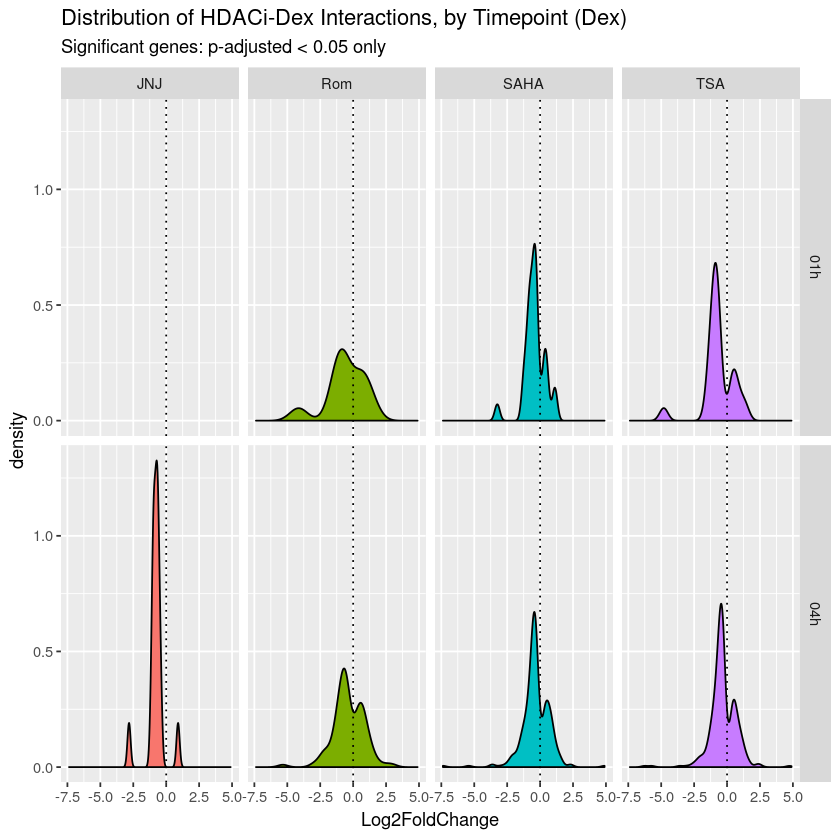

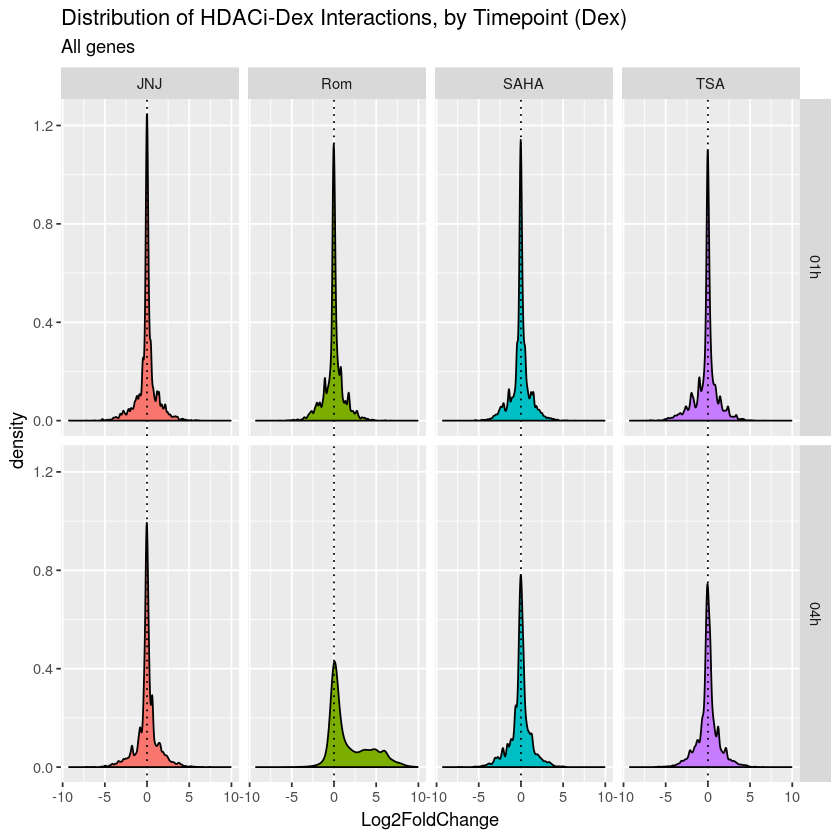

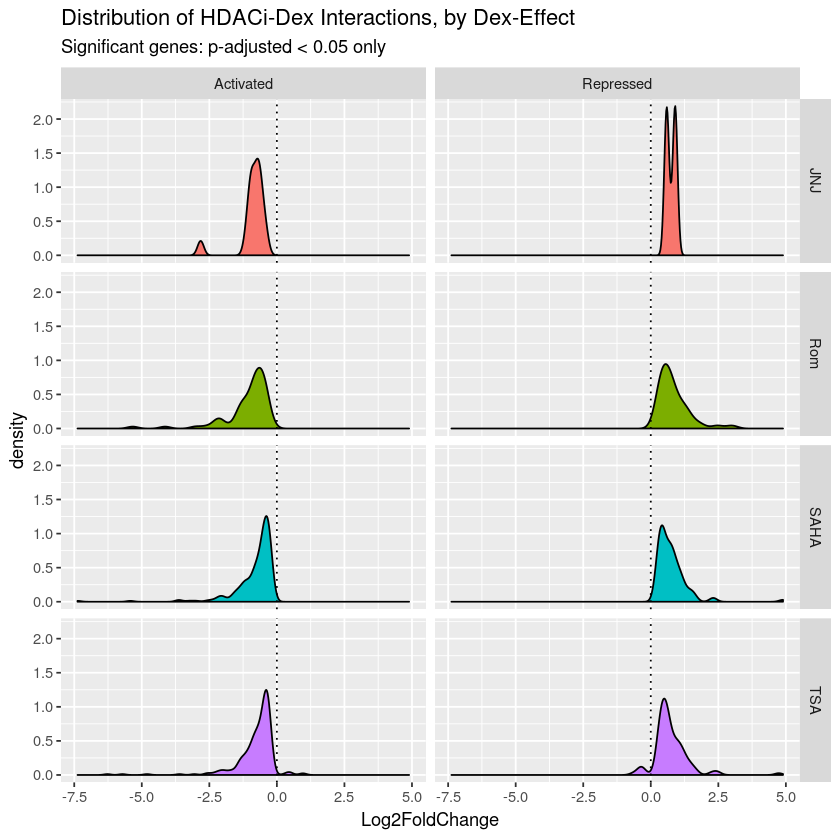

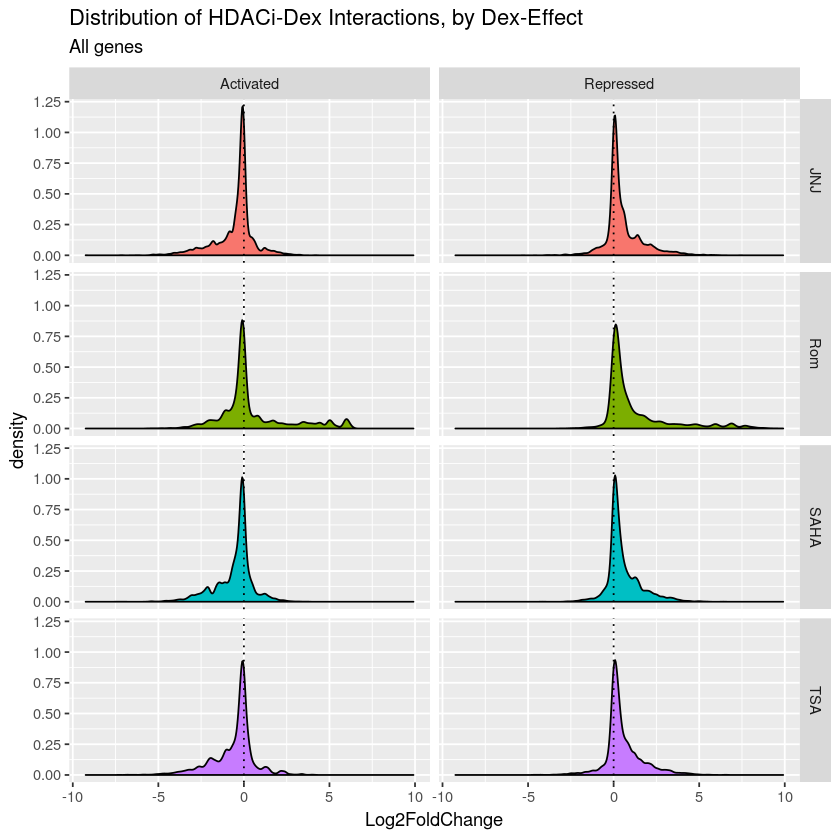

In [34]:
###################################
# Plot Dist by Time (significant) #
###################################

diff_res %>%
    filter(padj < 0.05) %>%
    ggplot(aes(x = log2FoldChange, fill = treatment)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dotted") +
    facet_grid(timepoint ~ treatment) +
    guides(fill = FALSE) +
    labs(title = "Distribution of HDACi-Dex Interactions, by Timepoint (Dex)",
         subtitle = "Significant genes: p-adjusted < 0.05 only",
         x = "Log2FoldChange")

###################################
#     Plot Dist by Time (all)     #
###################################
diff_res %>%
    ggplot(aes(x = log2FoldChange, fill = treatment)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dotted") +
    facet_grid(timepoint ~ treatment) +
    guides(fill = FALSE) +
    labs(title = "Distribution of HDACi-Dex Interactions, by Timepoint (Dex)",
         subtitle = "All genes",
         x = "Log2FoldChange")


##########################################
# Plot Dist by Dex-Effect (significant)  #
##########################################
diff_res %>%
    filter(padj < 0.05) %>%
    mutate(dex_direction = case_when(dex_effect > 0 ~ "Activated",
                                     dex_effect < 0 ~ "Repressed",
                                     TRUE ~ NA_character_)) %>%
    ggplot(aes(x = log2FoldChange, fill = treatment)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dotted") +
    facet_grid(treatment ~ dex_direction) +
    guides(fill = FALSE) +
    labs(title = "Distribution of HDACi-Dex Interactions, by Dex-Effect",
         subtitle = "Significant genes: p-adjusted < 0.05 only",
         x = "Log2FoldChange")

##########################################
#       Plot Dist by Dex-Effect (all)    #
##########################################
diff_res %>%
    mutate(dex_direction = case_when(dex_effect > 0 ~ "Activated",
                                     dex_effect < 0 ~ "Repressed",
                                     TRUE ~ NA_character_)) %>%
    ggplot(aes(x = log2FoldChange, fill = treatment)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dotted") +
    facet_grid(treatment ~ dex_direction) +
    guides(fill = FALSE) +
    labs(title = "Distribution of HDACi-Dex Interactions, by Dex-Effect",
         subtitle = "All genes",
         x = "Log2FoldChange")

## Plot dex-effect vs. interaction (Dex:HDACi) term

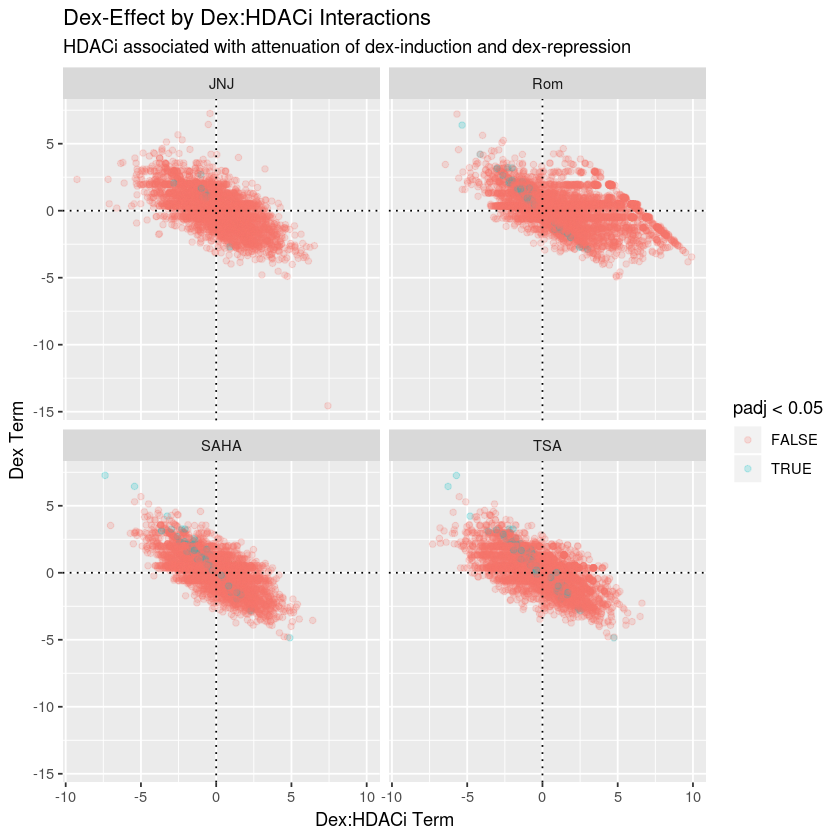

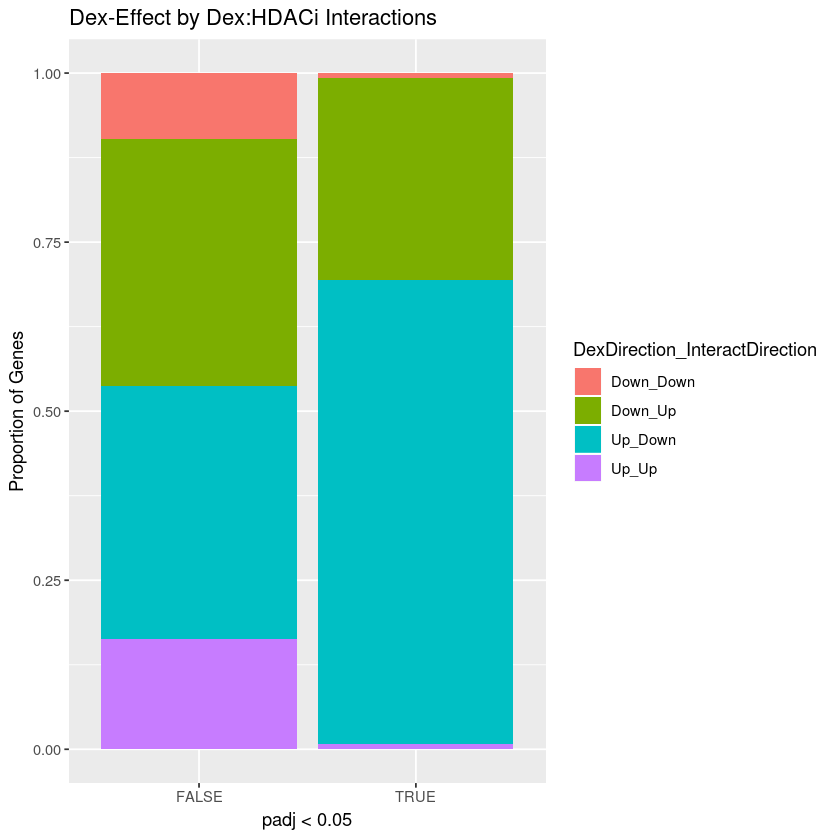

In [37]:
diff_res %>%
    ggplot(aes(x = dex_hdaci_effect, y = dex_effect, color = padj < 0.05 & !is.na(padj))) +
    geom_point(alpha = 0.2) +
    facet_wrap(~ treatment, nrow = 2, ncol = 2) +
    geom_vline(xintercept = 0, linetype = "dotted") +
    geom_hline(yintercept = 0, linetype = "dotted") +
    labs(title = "Dex-Effect by Dex:HDACi Interactions",
         subtitle = "HDACi associated with attenuation of dex-induction and dex-repression",
         x = "Dex:HDACi Term",
         y = "Dex Term",
         color = "padj < 0.05") 

diff_res %>%
    mutate(dex_direction = case_when(dex_effect > 0 ~ "Up",
                                     dex_effect < 0 ~ "Down",
                                     dex_effect == 0 ~ NA_character_),
           interact_direction = case_when(dex_hdaci_effect > 0 ~ "Up",
                                          dex_hdaci_effect < 0 ~ "Down",
                                          TRUE ~ NA_character_)) %>%
    group_by(significant = padj < 0.05 & !is.na(padj)) %>%
    dplyr::count(dex_direction, interact_direction) %>%
    mutate(prop = n / sum(n)) %>%
    ungroup() %>%
    ggplot(aes(x = significant, y = prop, fill = paste(dex_direction, interact_direction, sep = "_"))) +
    geom_bar(stat = "identity") +
    labs(title = "Dex-Effect by Dex:HDACi Interactions",
         x = "padj < 0.05",
         y = "Proportion of Genes",
         fill = "DexDirection_InteractDirection")


## Genes w/ Highest Attenuating Effect

In [38]:
# 01h
cat("\n --- Genes at 1hr --- \n")
diff_res %>%
    filter(!is.na(padj), padj < 0.05, timepoint == "01h") %>%
    arrange(desc(abs(dex_hdaci_effect))) %>%
    head(20) %>%
    dplyr::select(hgnc_symbol, log2FoldChange, padj, treatment, timepoint, dex_effect, hdaci_effect, dex_hdaci_effect)

# 04h
cat("\n --- Genes at 4hr --- \n")

diff_res %>%
    filter(!is.na(padj), padj < 0.05, timepoint == "04h") %>%
    arrange(desc(abs(dex_hdaci_effect))) %>%
    head(20) %>%
    dplyr::select(hgnc_symbol, log2FoldChange, padj, treatment, timepoint, dex_effect, hdaci_effect, dex_hdaci_effect)


 --- Genes at 1hr --- 


hgnc_symbol,log2FoldChange,padj,treatment,timepoint,dex_effect,hdaci_effect,dex_hdaci_effect
CIDEC,-4.8048383,1.219543e-04,TSA,01h,4.2217136,-0.06782487,-4.8048383
CIDEC,-4.1378814,1.631755e-04,Rom,01h,4.2044019,-1.34733948,-4.1378814
CIDEC,-3.2492268,3.303121e-03,SAHA,01h,4.2287665,-0.84275438,-3.2492268
TSC22D3,-1.4423671,1.334481e-16,TSA,01h,2.1811797,0.23235920,-1.4423671
NR4A2,1.4083176,1.442888e-11,TSA,01h,-1.3998707,-1.13451269,1.4083176
NR4A2,1.3767002,5.852850e-05,Rom,01h,-1.4141078,-1.03790069,1.3767002
TSC22D3,-1.3360967,2.266384e-04,Rom,01h,2.1696665,-0.27962960,-1.3360967
BCL6,-1.3126986,3.645017e-34,TSA,01h,1.3545336,1.43993142,-1.3126986
TNFAIP3,-1.2490469,2.840193e-04,TSA,01h,1.8508235,2.21639999,-1.2490469
BCL6,-1.2453922,7.023235e-37,SAHA,01h,1.3626267,1.55144052,-1.2453922



 --- Genes at 4hr --- 


hgnc_symbol,log2FoldChange,padj,treatment,timepoint,dex_effect,hdaci_effect,dex_hdaci_effect
IP6K3,-7.379403,8.316881e-04,SAHA,04h,7.268166,-0.50175784,-7.379403
CIDEC,-6.270591,4.480293e-15,TSA,04h,6.442280,-0.06782487,-6.270591
IP6K3,-5.717516,1.993821e-03,TSA,04h,7.263866,-0.53396068,-5.717516
CIDEC,-5.424479,5.450624e-10,SAHA,04h,6.446629,-0.84275438,-5.424479
CIDEC,-5.336431,5.451049e-09,Rom,04h,6.383126,-1.34733948,-5.336431
POU3F2,4.893931,1.559206e-02,SAHA,04h,-4.849207,3.42864194,4.893931
POU3F2,4.736179,1.952023e-02,TSA,04h,-4.855923,3.58358260,4.736179
MME,-3.632080,3.666338e-02,SAHA,04h,3.139604,6.53205427,-3.632080
RSPO2,-3.623313,4.000355e-06,SAHA,04h,3.115022,4.76169687,-3.623313
RSPO2,-3.601135,6.740601e-07,TSA,04h,3.108014,5.11541621,-3.601135


## Interpretation

It seems that among the significant interactions for Dex_HDACi, there is a general trend of attenuation for dex-response and HDACi, as noted by the negative slope in the graphs for significant genes. This can be interpreted as follows: **high dex-effect is associated with negative HDACi effect in the presence of dex** and vice versa.

## Distribution of effect sizes per HDACi

We plot the distribution of effect sizes across all treatments. We define effect size as the combined `log2FoldChange` of HDACi + Dex on a gene in comparison to control (no dex, no HDACi). For example, a `LFC = -2.5` would represent that the combined effect of Dex + HDACi resulted in expression that is `0.177` times that of no dex and no HDACi.  

For these plots, let the `DMSO` graphs represent only the effect of `dex` on differential gene expression, so that we have a visualization of the control:

----- Summary Statistics of padj  < 0.05 -----

treatment,timepoint,meanLFC,medianLFC
DMSO,01h,0.2379528,0.1915543
DMSO,04h,0.2533951,0.2465366
JNJ,01h,0.2645987,0.1608496
JNJ,04h,0.2441555,0.1987088
Rom,01h,0.6549902,0.3301870
Rom,04h,1.0310137,0.5497935
SAHA,01h,0.6872740,0.3920170
SAHA,04h,0.6520370,0.3633575
TSA,01h,0.8170290,0.4726949
TSA,04h,0.8273407,0.4136541


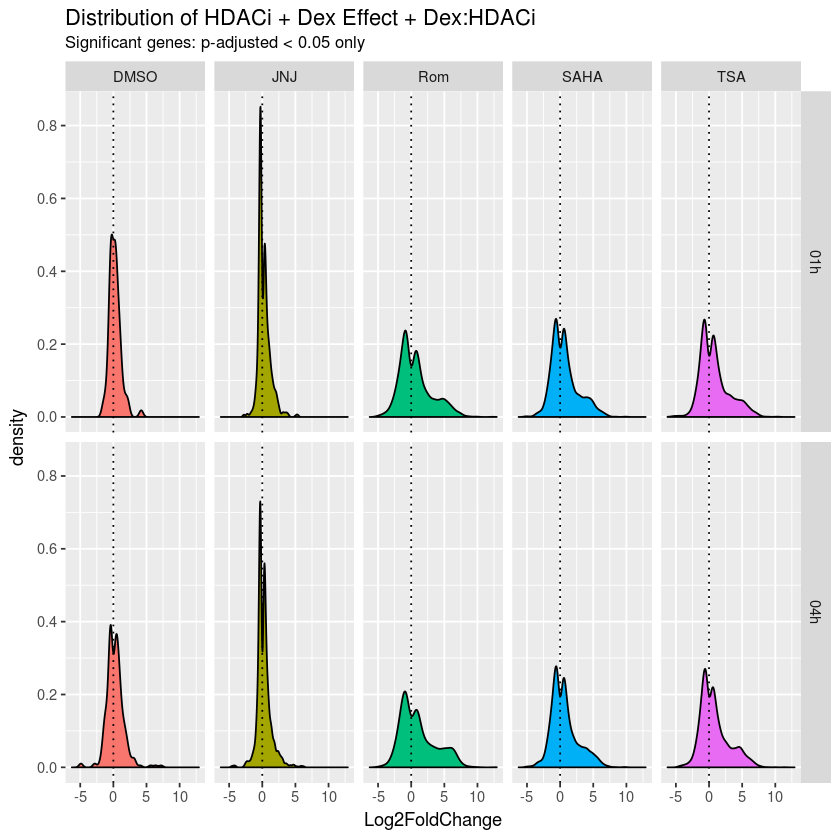

----- Summary Statistics for all genes -----

treatment,timepoint,meanLFC,medianLFC
DMSO,01h,0.05311993,3.999523e-02
DMSO,04h,-0.01075350,-6.767627e-05
JNJ,01h,0.10774816,4.410540e-02
JNJ,04h,0.08274663,1.015824e-02
Rom,01h,0.48043770,2.326884e-01
Rom,04h,2.13867229,1.228146e+00
SAHA,01h,0.55596315,4.025758e-01
SAHA,04h,0.50530124,3.554761e-01
TSA,01h,0.48520401,1.667830e-01
TSA,04h,0.67158938,4.186228e-01


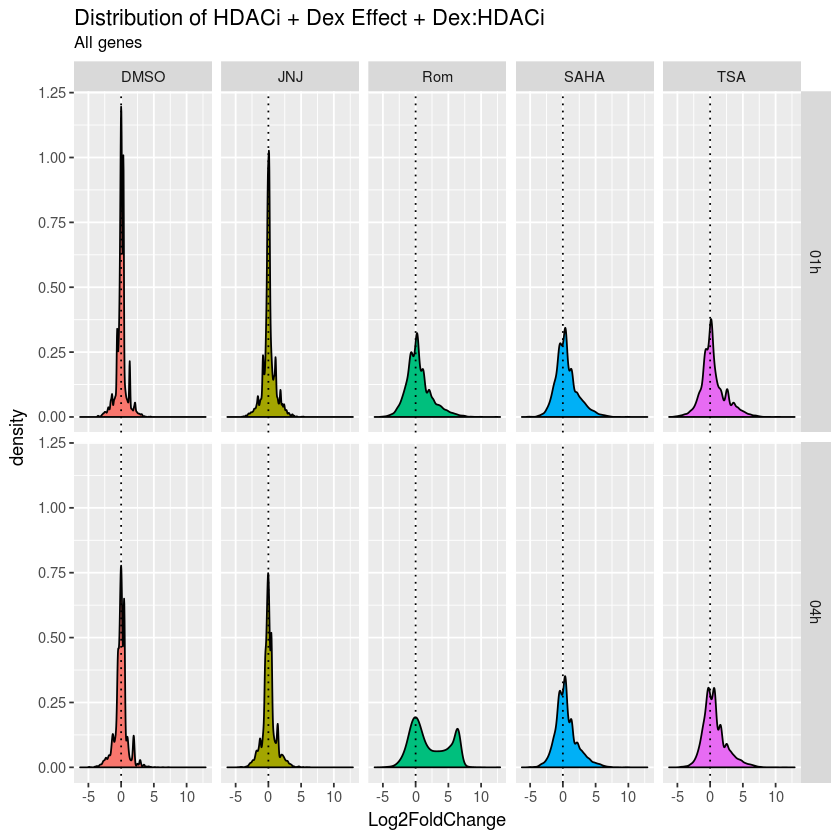

In [24]:
############################
# Plot Dist. (significant) #
############################

res %>%
    filter(padj < 0.05) %>%
    ggplot(aes(x = log2FoldChange, fill = treatment)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dotted") +
    facet_grid(timepoint ~ treatment) +
    guides(fill = FALSE) +
    labs(title = "Distribution of HDACi + Dex Effect + Dex:HDACi",
         subtitle = "Significant genes: p-adjusted < 0.05 only",
         x = "Log2FoldChange")

cat("----- Summary Statistics of padj  < 0.05 -----")
res %>%
    filter(padj < 0.05) %>%
    group_by(treatment, timepoint) %>%
    summarise(meanLFC = mean(log2FoldChange), medianLFC = median(log2FoldChange)) %>%
    ungroup()

############################
#     Plot Dist. (all)     #
############################
res %>%
    ggplot(aes(x = log2FoldChange, fill = treatment)) +
    geom_density() +
    geom_vline(xintercept = 0, linetype = "dotted") +
    facet_grid(timepoint ~ treatment) +
    guides(fill = FALSE) +
    labs(title = "Distribution of HDACi + Dex Effect + Dex:HDACi",
         subtitle = "All genes",
         x = "Log2FoldChange")

cat("----- Summary Statistics for all genes -----")
res %>%
    group_by(treatment, timepoint) %>%
    summarise(meanLFC = mean(log2FoldChange), medianLFC = median(log2FoldChange)) %>%
    ungroup()

## Main observations

* Significant increases in differential expression across all HDACis for both up and downregulated genes, suggesting **blunting** of dex response.

* Interaction effects between Dex and HDACi show that there is an **attenuation** effect, that is, HDACi blunts the dex-response through a currently unknown mechanism.

* Blunting of dex-response appears to be global; does not select for up-regulated or down-regulated genes.

* Using regression model, **Dex:HDACi** terms largely appear to be **negative** (`LFC < 0`) while Dex terms largely appear positive (`LFC > 0`).

* Genes largely appear to be common between **Dex-HDACi samples**, suggesting similar effects for Dex + general HDACi. Few genes shared in common with Dex-HDACI and Dex-only samples, suggesting that there are significant differences in biological expression between Dex only and Dex + HDACi.

## Main questions and future leads:
* How do we explain decreases in differential expression (blunting) of dex-response for HDACi samples?
    * HDACs could be required for **assembly of response complexes**?
        * Western Blot of some sort?
        
    * HDACs could play a **structural role** (GR is a substrate for HDAC2, and when cytoplasmic HDACs are inhibited, suppression of immune response can no longer occur)
        * KO of HDAC2 + RNA Seq would allow us to see if this is a GR-independent event
        
    * HDACs **required for GR binding, transport to nucleus (formation of homodimer)**
        * Can be answered by GR ChIP + Rom and H3K27ac ChIP + Rom
        
* Are the genes that shifted regulation vital components in dex-response?
    * From the looks of it...yes. Dex + HDACi inhibits the suppression of NF$\kappa$B and other anti-inflammatory proteins, suggesting that adding HDACi inhibits Dex anti-inflammatory effects.
        * Cross-reference Diff-Expression results from Dex-Only studies with results from Dex-HDACi results.
    * Also, Dex + HDACi shows increase in expression of inflammatory proteins (NF$\kappa$B2), further offsetting anti-inflammatory response.
        * HDACs are vital to the SUPPRESSION of inflammation in presence of GR, which matches literature.

## Write out all DESeq2 Results to File

In [53]:
res %>%
    write_csv("gr_hdaci_all.csv")